# Gaussian Model

## 1.a Swaption pricing by Monte Carlo under Risk neutral measure

The swaption price at time 0, $V_0$, is given by the following expression $$
    \begin{array}{ll} V_0 &= \mathbb{E}_{\mathbb{Q}}\Big[e^{-\int_{0}^{T_0} r(s) \ \mathrm{d}s}Swap(T_0)^+\Big] \\
&= P(0,T_0) \ \mathbb{E}_{\mathbb{Q}}\Big[e^{-\int_{0}^{T_0} x(s) \ \mathrm{d}s}\Big(1-P(T_0,T_N,x(T_0),y(T_0))-K\sum_{n=0}^{N-1} \tau_n P(T_0,T_{n+1},x(T_0),y(T_0)\Big)^+\Big]
\end{array}
$$
And $$\forall n \in [|0,N|], \quad P(T_0,T_n,x,y) = \frac{P(0,T_n)}{P(0,T_0)} e^{-G(T_0,T_n)x-\frac{1}{2}G(T_0,T_n)^2 y}$$

One will use a Monte Carlo estimator of the expectation above by using M independent simulations $S_m$ so that
$$\hat{V_0} = \frac{1}{M} \sum_{m=1}^M S_m$$
$$\forall m, \ S_m = e^{I_m} \ \Big(P(0,T_0)-P(0,T_0)P(T_0,T_N,x_m,y_m) - KP(0,T_0) A(T_0,x_m,y_m)\Big)^+$$
Where we have noted $x_m,y_m,I_m$ the m-th Euler simulation of $x(T_0),y(T_0), I(T_0)$ and 
$$A(t,x,y) = \sum_{n=0}^{N-1} \tau_n \frac{P(0,T_{n+1})}{P(0,t)} e^{-G(t,T_{n+1})x - \frac{1}{2}G(t,T_{n+1})^2 y}$$

## 1.b Swaption pricing by Monte Carlo under other measure

Here we aim to get rid of the path dependent term in the expectation $e^{-\int_{0}^{T_0} x(s) \ \mathrm{d}s}$ by introducing an appropriate probability measure. A common solution is to choose a zero coupon bond as numeraire. But a preferable choice is a numeraire which remains alive at all dates of the tenor structure, that's why the so called **terminal measure**, with $P(t,T_N)$ as numeraire is a good choice.

$\big(e^{-\int_{0}^{t} r(s) \ \mathrm{d}s}P(t,T_N)\big)_t$ is a strictly positive martingale under the risk neutral measure, so let $$\frac{\mathrm{d}\mathbb{Q}^{T_N}}{\mathrm{d}\mathbb{Q}}\Big| _{\mathcal{F}_t} = \frac{P(t,T_N)}{P(0,T_N)} e^{-\int_{0}^{t} r(s) \ \mathrm{d}s}$$

It implies $$\begin{array}{ll} V_0 &= P(0,T_N) \ \mathbb{E}_{\mathbb{Q}^{T_N}}\Big[ \frac{1}{P(T_0,T_N)} \big(Swap(T_0)\big)^+\Big] \\
&= P(0,T_N) \ \mathbb{E}_{\mathbb{Q}^{T_N}}\Big[ \frac{1}{P(T_0,T_N)} \Big(1 -P(T_0,T_N,x(T_0),y(T_0)) - K \sum_{n=0}^{N-1} \tau_n \frac{P(0,T_{n+1})}{P(0,T_0)} e^{-G(T_0,T_{n+1})x(T_0)-\frac{1}{2}G(T_0,T_{n+1})^2 y(T_0)} \Big)^+ \Big] \end{array}$$

Now let's focus on the dynamics of $x$ and $y$ under the new measure. To begin with, in the absence of arbitrage, the discounted $T_N$ bond is a martingale under the risk neutral measure, so:
$$\mathrm{d}\big(\frac{P(t,T_N)}{\beta(t)}\big) = - \frac{P(t,T_N)}{\beta(t)} \sigma_P(t,T_N)^\top \ \mathrm{d}W_t$$ where $\beta(t) = e^{-\int_{0}^{t} r(s) \ \mathrm{d}s}$.

$$\implies \frac{P(t,T_N)}{\beta(t)} = P(0,T_N) e^{-\int_{0}^{t} \sigma_P(s,T_N)^\top \ \mathrm{d}W_s - \frac{1}{2} \int_{0}^{t} \sigma_P(s,T_N)^\top \sigma_P(s,T_N) \ \mathrm{d}s}$$

By Girsanov's therorem, $$\boxed{W^{T_N}_t = W_t + \int_{0}^{t} \sigma_P(s,T_N) \ \mathrm{d}s} \quad \text{is a BM under } \mathbb{Q}^{T_N}$$

Recall that is the assumptions of the model, $\sigma_f(t,T) = g(t)h(T)$ and $\sigma_P(t,T) = \int_{t}^{T} \sigma_f(t,u) \ \mathrm{d}u = g(t) \int_{t}^{T} h(u) \ \mathrm{d}u = \sigma_r(t) G(t,T)$

Then $$\boxed{\begin{array}{ll} \mathrm{d}x(t) &= \big(y(t) - \chi(t) x(t)\big) \ \mathrm{d}t \ + \ \sigma_r(t) \ (\mathrm{d}W^{T_N}_t - \sigma_P(t,T_N) \mathrm{d}t) \\
&= \big(y(t) -\sigma_r(t)^2 G(t,T_N) - \chi(t) x(t)\big) \ \mathrm{d}t \ + \ \sigma_r(t) \ \mathrm{d}W^{T_N}_t \end{array}}$$

The condition for $x(t) \ge \frac{-a(t)}{b(t)}$ in this measure is not as obvious as under the risk neutral measure.

## 2.a Euler discretization under Risk neutral measure

We aim to discretize the following differential system with an Euler scheme

$$\left\{
    \begin{array}{ll}
       \mathrm{d}x(t) &= (y(t) - \chi(t) x(t)) \ \mathrm{d}t \ + \ \sigma_r(t) \ \mathrm{d}Wt\\
       \mathrm{d}y(t) &= (\sigma_r(t)^2-2\chi(t)y(t)) \ \mathrm{d}t
    \end{array}
\right.$$

**Constant mean reversion and linear local volatility:** First, let for simplicity $$\chi(t) = \chi \in \mathbb{R}$$ and $$\sigma_r(t) = \sigma_r(t,x(t),y(t)) = \lambda(a + bx(t))$$

One defines a discretized time interval $0=t_0 < t_1 < ... < t_N = T_0$ and $\forall i \in [|0,N-1|], \ \Delta_i = t_{i+1} -t_i$

We will simulate $x(T_O)$ and $y(T_O)$ thanks to the scheme:
$$\left\{
    \begin{array}{ll}
       x_{t_{i+1}} &= x_{t_i} + (y_{t_i} - \chi x_{t_i}) \ \Delta_i \ + \ \lambda(a+bx_{t_i}) \ \sqrt{\Delta_i} Z_i \qquad  ,Z_i \sim \mathcal{N}(0,1) \\
       y_{t_{i+1}} &= y_{t_i} + (\lambda^2(a+bx_{t_i})^2-2\chi y_{t_i}) \ \Delta_i
    \end{array}
\right.$$

What's more, one has to simulate the variable $$I(T_0)=-\int_{0}^{T_0} x(s) \ \mathrm{d}s$$
As $\mathrm{d}I(t) = -x(t) \ \mathrm{d}t$, in line with the results above, one defines
$$I_{t_{i+1}} = I_{t_i} - x_{t_i} \ \Delta_i$$

**Remark:** The explicit Euler scheme is described above, but it is possible to implement implicit Euler scheme instead to avoid unstability.


**Other possibility:** Furthermore one can show (see penultimate equation in the proof of the bound of the diffusion $x$) that: 
$$x(t) + \frac{a}{b} = \frac{1}{X_t} \big( \frac{a}{b} + \int_{0}^{t} X_s (\frac{a\chi}{b} + y(s)) \ \mathrm{d}s\big), \\
X_t = e^{\chi t + \frac{b^2}{2}t - b W_t}$$

Then $$\mathrm{d}x(t) = \Big( \frac{a}{b} + \int_{0}^{t} e^{\chi s + \frac{b^2}{2}s - b W_s} \big( \frac{a\chi}{b}+ y(s) \big) \ \mathrm{d}s \Big) \ X_t^{-1} \ \Big[ - \chi \mathrm{d}t + b \mathrm{d}W_t \Big] + (\frac{a\chi}{b} + y(t) ) \mathrm{d}t $$

If $I(t) = \int_{0}^{t} e^{\chi s + \frac{b^2}{2}s - b W_s} \big(\frac{a\chi}{b} + y(s) \big) \ \mathrm{d}s$,

$$\left\{
    \begin{array}{ll}
       x_{t_{i+1}} &= x_{t_i} + X_{t_i}^{-1} \big( \frac{a}{b} + I_{t_i} \big) \big( -\chi \Delta + b \sqrt{\Delta} Z_i \big) + \Delta \ \big(\frac{a\chi}{b} + y_{t_i} \big)\\
       y_{t_{i+1}} &= y_{t_i} + (\lambda^2(a+bx_{t_{i+1}})^2-2\chi y_{t_i}) \ \Delta_i \\
       I_{t_{i+1}} &= I_{t_i} + e^{\chi t_i + \frac{b^2}{2}t_i - b \sqrt{\Delta_i} \sum_{j=0}^{i-1}Z_j} (\frac{a \chi}{b} + y_{t_i}) \ \Delta_i
    \end{array} \right.$$


## 2.b Implicit Euler scheme

### 2.b.1
The implicit scheme for $(x,y)$ writes $$\left\{
    \begin{array}{ll}
       x_{t_{i+1}} &= x_{t_i} + (y_{t_{i+1}} - \chi x_{t_{i+1}}) \ \Delta_i \ + \ \lambda(a+bx_{t_i}) \ \sqrt{\Delta_i} Z_i \qquad  ,Z_i \sim \mathcal{N}(0,1) \\
       y_{t_{i+1}} &= y_{t_i} + (\lambda^2(a+bx_{t_{i+1}})^2-2\chi y_{t_{i+1}}) \ \Delta_i
    \end{array} \right.
\\
\iff \begin{pmatrix}
x_{t_{i+1}} \\ y_{t_{i+1}} \end{pmatrix} = \begin{pmatrix} x_{t_i} \\ y_{t_i} \end{pmatrix} + \begin{pmatrix} f_1(t_{i+1},x_{t_{i+1}},y_{t_{i+1}}) \\ f_2(t_{i+1},x_{t_{i+1}},y_{t_{i+1}}) \end{pmatrix} \Delta_i + \begin{pmatrix} \lambda(a+bx_{t_i}) \\ 0 \end{pmatrix} \sqrt{\Delta_i} Z_i \\
\iff \begin{pmatrix}
x_{t_{i+1}}-f_1(t_{i+1},x_{t_{i+1}},y_{t_{i+1}}) \Delta_i \\ y_{t_{i+1}} -f_2(t_{i+1},x_{t_{i+1}},y_{t_{i+1}}) \Delta_i \end{pmatrix} = \begin{pmatrix} x_{t_i} \\ y_{t_i} \end{pmatrix} + \begin{pmatrix} \lambda(a+bx_{t_i}) \\ 0 \end{pmatrix} \sqrt{\Delta_i} Z_i$$

And one solves each iteration by a Newton-Raphson algorithm in dimension 2.

### 2.b.2

Another method would be to implement an implicit scheme in $x$ and an explicit scheme in $y$ to get ride of the non linear term of $x_{t_{i+1}},y_{t_{i+1}}$ in the full implicit scheme.

One has $$\left\{
    \begin{array}{ll}
       x_{t_{i+1}}(1+ \chi \Delta_i) &= x_{t_i} + y_{t_{i+1}} \ \Delta_i \ + \ \lambda(a+bx_{t_i}) \ \sqrt{\Delta_i} Z_i \qquad  ,Z_i \sim \mathcal{N}(0,1) \\
       y_{t_{i+1}} &= y_{t_i} + (\lambda^2(a+bx_{t_{i}})^2-2\chi y_{t_{i}}) \ \Delta_i
    \end{array} \right.$$

## 2.c log-Euler scheme

As the explicit Euler scheme involves Gaussian increments, the discretized diffusion of $x$ can take values from $-\infty$ to $+\infty$. However we have shown that the real diffusion $x$ is bounded from below by $- \frac{a(t)}{b(t)}, \ \forall t \ge 0$. To reproduce an approximation of $x$ which satisfies this condition on can implement the so called **log-Euler scheme**.

The method consists in applying the Euler scheme on an invertible transformation of $x$. 
Let $x(t) = f(u(t))$ such that $\forall t, f(u(t)) \ge - \frac{a(t)}{b(t)}$. 

For instance, $$x(t) = e^{u(t)} - \frac{a(t)}{b(t)}. \quad \iff u(t) = \ln \big( x(t) + \frac{a(t)}{b(t)}\big)$$

If $$\mathrm{d}x(t) = \mu(t,x(t)) \mathrm{d}t + \sigma(t,x(t)) \ \mathrm{d}W_t$$, one has by Itô's lemma:

$$\begin{array}{ll} \mathrm{d}u(t) &= \frac{\big(\frac{a(t)}{b(t)}\big)'}{x(t) + \frac{a(t)}{b(t)}} \ \mathrm{d}t + \frac{1}{x(t) + \frac{a(t)}{b(t)}} \ \mathrm{d}x(t) -\frac{1}{2} \frac{1}{\big(x(t) + \frac{a(t)}{b(t)}\big)^2} \sigma^2(t,x(t)) \ \mathrm{d}t \\
&= \Big[ \big(\frac{a(t)}{b(t)}\big)' + \mu(t,x(t)) -\frac{1}{2} \frac{\sigma^2(t,x(t))}{x(t) + \frac{a(t)}{b(t)}} \Big] \frac{1}{x(t) + \frac{a(t)}{b(t)}} \ \mathrm{d}t + \frac{\sigma(t,x(t))}{x(t) + \frac{a(t)}{b(t)}} \ \mathrm{d}W_t \\
&= \alpha(t,x(t)) \ \mathrm{d}t + \gamma(t,x(t)) \ \mathrm{d}W_t \end{array}$$

Then $$\begin{array}{ll} \hat{u}_{i+1} &= \hat{u}_{i} + \alpha(t_i,\hat{x}_i) \ \Delta_i + \gamma(t_i,\hat{x}_i) \ \sqrt{\Delta_i} Z_i \\
\iff \ln \big(\hat{x}_{i+1} + \frac{a(t_{i+1})}{b(t_{i+1})}\big) &= \ln \big(\hat{x}_{i} + \frac{a(t_{i})}{b(t_{i})} \big) + \alpha(t_i,\hat{x}_i) \ \Delta_i + \gamma(t_i,\hat{x}_i) \ \sqrt{\Delta_i} Z_i \end{array}$$

Finally $$\boxed{\hat{x}_{i+1} = -\frac{a(t_{i+1})}{b(t_{i+1})} + \hat{x}_i + \frac{a(t_{i})}{b(t_{i})} + e^{\alpha(t_i,\hat{x}_i) \ \Delta_i + \gamma(t_i,\hat{x}_i) \ \sqrt{\Delta_i} Z_i}}$$

Furthermore, one sees that if $x(0) > - \frac{a(0)}{b(0)}$, by recurrence our approximated scheme is over the expected 
bound, that's $$\forall i \in [|0,N|], \ \hat{x}_i > -\frac{a(t_i)}{b(t_i)}$$

**Case of linear local volatility:**

In our assumptions, $\mu(t,x) = y(t) - \chi x \ , \quad \sigma(t,x) = \sigma_r(t,x) =  \lambda ( a + bx)$ which yields 
$$\left\{
    \begin{array}{ll}
       \alpha(t,x(t)) = \frac{b \lambda}{\sigma_r(t,x(t))} \big[ y(t)- \chi x(t)\big] - \frac{(b\lambda)^2}{2} \\
       \gamma(t,x(t)) = b \lambda
    \end{array}
\right.$$

The log-Euler scheme writes $$\hat{u}_{i+1} = \hat{u}_{i} + \Big(\frac{b \lambda}{\sigma_r(t_i,\hat{x}_i)} \big[ \hat{y}_i- \chi \hat{x}_i\big] - \frac{(b\lambda)^2}{2} \Big) \ \Delta_i + b \lambda \ \sqrt{\Delta_i} Z_i$$

And $$\hat{u}_0 = \ln a/b , \quad \hat{x}_i = e^{\hat{u}_i} - \frac{a}{b}$$

**Remark: To avoid problems as $\lambda$ becomes near to zero, it is preferable to write $\frac{b}{(a+b \hat{x}_i)}$ instead of $\frac{b \lambda}{\sigma_r(t_i,\hat{x}_i)}$.**

**The fact that we take the exponential of $\hat{u}$ at each step leads to the possibility of some unstability. One solution to tackle that issue is to implement the implicit version of this scheme.**

## 2.d Implicit log-Euler scheme

$$\begin{array}{ll}
\hat{u}_{i+1} = \hat{u}_{i} + \Big(\frac{b \lambda}{\sigma_r(t_{i+1},\hat{x}_{i+1})} \big[ \hat{y}_{i+1}- \chi \hat{x}_{i+1}\big] - \frac{(b\lambda)^2}{2} \Big) \ \Delta_i + b \lambda \ \sqrt{\Delta_i} Z_i \\
\iff \hat{u}_{i+1} - \Delta_i e^{-\hat{u}_{i+1}} \big(\hat{y}_{i+1} + \frac{\chi a}{b} \big) = \hat{u}_i - \Delta_i \big( \chi + \frac{(b \lambda)^2}{2} \big) + b \lambda \sqrt{\Delta_i} Z_i
\end{array}$$

One can see that the implicit scheme requires to compute an inversion at each step of the algorithm. The function to be inverted is $$f_i: \ x \rightarrow x - \Delta_i e^{-x} \big(y_{i+1} + \frac{\chi a}{b} \big)$$ and is easily differentiable. An inversion method such as the Newton-Raphson algorithm can therefore be used.

**(Other scheme: Quadratic exponential scheme)**

### ZC curve 

In order to price swaptions, one needs the values of the zero coupon bonds for each maturity $\Big(P(0,T_i)\Big)_{i=0,N}$. One can calculate it with $$P(0,T_i) = e^{-\int_{0}^{T_i}f(0,u) \ \mathrm{d}u}$$, but one needs again **the initial forward curve** $t \rightarrow f(0,t)$


To do some calculations and to have a first simple approach, I have chosen to fixe $P(0,T) = e^{-rT}$, in other words one assumes the initial forward rate $f(0,t)$ constant.

We also add Zero coupon data from 0 to 50 Y with a semi annual basis from a bootsrapping method on par swap rate.

## 3.Useful functions

In [1]:
#modules

import numpy as np
import math
from random import *
from time import time
import scipy.stats as stats
import scipy.integrate as integrate
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(10)

un_sur_sqrt_pi = 1/(np.sqrt(2*np.pi))

def gaussian_density(x):
    return un_sur_sqrt_pi*np.exp(-0.5*x**2)

In [2]:
#Plotting functions

def plot2D(x,y,xlabel,ylabel,title,z=[],zlabel=''):
    plt.figure()
    plt.xlabel(xlabel)
    plt.title(title)
    plt.plot(x,y,label=ylabel)
    if z != []:
        plt.plot(x,z,label=zlabel)
    plt.legend()
    plt.show()
    
def plot3D(X, Y, Z,angle):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_xlabel('K')
    ax.set_ylabel('T0')
    ax.set_zlabel('vol')
    ax.set_title('Implied vol')
    ax.view_init(40,angle)

In [3]:
#import ZC data P(0.5*j) j=0,100
import csv
ZC = []
with open('./ZC.csv') as my_file:
    my_file_reader = csv.reader(my_file, delimiter=',', quotechar='"')
    for x in my_file_reader:
        ZC.append([float(y) for y in x])
ZC = ZC[0]

In [4]:
#One set the parameters
chi = 1
lmbda = 1
a = 1
b = 1
K = 0.05
N = 250
M = 10000
r = 0.05

# tenor for tests
maturities = np.arange(0.5,6,0.5)     #tenor structure of the underlying swap T0=6M,1Y,...5.5Y=TN
T0 = maturities[0]
TN = maturities[-1]
#bonds from data
bonds_data = ZC[int(T0*2):int(maturities[-1]*2)+1]  #P(0,T_i) for T_i in maturities
#bonds approximation
bonds = [np.exp(-r*t) for t in maturities]

## 4.Simulation under risk neutral measure

In [5]:
#Simulation of the diffusions x,y,I 

def simul(lmbda,a,b,chi,T0,N,M,scheme = "log-Euler"):
    delta = T0/N
    resu = []
    C = b*lmbda
    if(scheme == "log-Euler"):
        for m in range(M):
            (u,x,y,I) =(np.log(a/b),0,0,0)
            Z = np.random.standard_normal(N)
            for i in range(N):
                sigma_i = lmbda*(a+b*x)
                I = I - x*delta
                u = u + (b*(y-chi*x)/(a+b*x) -0.5*C**2) * delta + C * math.sqrt(delta) * Z[i]
                y = y + (sigma_i**2 -2*chi*y)*delta
                if(np.exp(u) - a/b > 1e10):
                    x = 1e10
                else:
                    x = np.exp(u) - a/b
            resu.append((x,y,I))
            
    elif (scheme == "Euler"):
        for m in range(M):
            (x,y,I) =(0,0,0)
            Z = np.random.standard_normal(N)
            for i in range(N):
                sigma_i = lmbda*(a+b*x)
                I = I - x*delta
                if(x + (y-chi*x)*delta + sigma_i*math.sqrt(delta)*Z[i] > 1e10):
                    x = 1e10
                else:
                    x = x +(y-chi*x)*delta + sigma_i*math.sqrt(delta)*Z[i]
                y = y + (sigma_i**2 -2*chi*y)*delta
            resu.append((x,y,I))
            
    elif (scheme == "Impli Euler"):
        for m in range(M):
            (x,y,I) =(0,0,0)
            Z = np.random.standard_normal(N)
            for i in range(N):
                sigma_i = lmbda*(a+b*x)
                I = I - x*delta
                y = y + (sigma_i**2 -2*chi*y)*delta
                x = (x + y*delta + sigma_i*math.sqrt(delta)*Z[i])/(1 + chi * delta)
            resu.append((x,y,I))
            
    elif (scheme == "Impli log-Euler"):
        for m in range(M):
            (u,x,y,I) =(np.log(a/b),0,0,0)
            Z = np.random.standard_normal(N)
            for i in range(N):
                sigma_i = lmbda*(a+b*x)
                I = I - x*delta
                y = y + (sigma_i**2 -2*chi*y)*delta
                arg = u - (chi + 0.5*C**2) * delta + C * math.sqrt(delta) * Z[i]
                u = opt.newton(lambda t: f(t,y,chi,a,b,delta) - arg,0,fprime = lambda t: 1 + delta*(y+ chi*a/b)*np.exp(-t))
                x = np.exp(u) - a/b
            resu.append((x,y,I))
    else:
        print("Unknown scheme")
    return resu

In [6]:
#test
s = simul(lmbda,a,b,chi,T0,N,1,"Euler")
print(s)

[(0.12585567811258108, 0.5866964762822574, -0.16571617450649986)]


In [7]:
#function G 
def G(t,T,chi):
    return (1-np.exp(chi*(t-T)))/chi

#payoff of the swaption at T0
def payoff_swaption(maturities,bonds,x,y,chi,K):
    T0 = maturities[0]                             #maturities = [T0,...,TN]
    nb_maturities = maturities.size
    A = 0
    #calculate the annuity A
    for n in range(nb_maturities-1):
        g = G(T0,maturities[n+1],chi)
        A += (maturities[n+1]-maturities[n])*bonds[n+1]*np.exp(-1*g*x-0.5*y*g**2)
    g = G(T0,maturities[-1],chi)
    swap = bonds[0] - bonds[-1]*np.exp(-1*g*x-0.5*y*g**2) - K*A
    if swap>0:
        return swap
    else:
        return 0

In [8]:
#test
(x,y,I) = s[0]
payoff_swaption(maturities,bonds,x,y,chi,K)

0.3179296734820921

In [9]:
#pricing of the swaption by Monte Carlo algorithm
#N is the parameter of discretization in the Euler scheme
#M is the number of simulations in the Monte Carlo estimation
#K is the strike of teh swaption
#return: Price and print the empirical variance 1/n sum( xi^2) - x_bar^2

def swaption_MC(M,sim,K,chi,bonds,maturities,exec_time=False,variance = False):
    t1 = time()
    Monte_Carlo = 0
    moment_2 = 0
    for m in range(M):
        (x,y,I) = sim[m]
        s_m = np.exp(I)*payoff_swaption(maturities,bonds,x,y,chi,K)
        Monte_Carlo += s_m
        moment_2 += s_m**2
    t2 = time()
    price = Monte_Carlo/M
    if(exec_time):
        print("Execution time: ",t2-t1, "sec")
    if(variance):
        var = moment_2/M - price**2
        print("Variance:",var)
    return price


In [10]:
#tests 
t_start = time()
sim = simul(lmbda,a,b,chi,T0,N,M,"Euler")

print(swaption_MC(M,sim,K,chi,bonds,maturities,True,True))
t_finish = time()
print("Total duration:",t_finish-t_start)

Execution time:  0.46978139877319336 sec
Variance: 0.04690076492360447
0.18113715327112503
Total duration: 8.749634504318237


In [11]:
t_start = time()
sim = simul(lmbda,a,b,chi,T0,N,M,"log-Euler")

print(swaption_MC(M,sim,K,chi,bonds,maturities,True,True))
t_finish = time()
print("Total duration:",t_finish-t_start)

Execution time:  0.46610379219055176 sec
Variance: 0.04761865600458329
0.18372437960228113
Total duration: 15.094031810760498


In [5]:
#Annuity in the model
#args: -maturities: array of the tenor dates 
#- bonds: array of the ZC curve at tenor dates P(0,T0)...P(0,TN)
#-ZC_t : value of P(0,t)
#- order: derivative with respect to x: A / A' / A''

def A(t,x,y,maturities,bonds,ZC_t,chi,order=0):
    nb_maturities = len(maturities)
    resu = 0
    for n in range(maturities.size-1):
        g = G(t,maturities[n+1],chi)
        resu += (-1)**order * (maturities[n+1]-maturities[n])*(bonds[n+1]/ZC_t)*np.exp(-1*g*x-0.5*y*g**2)*g**order
    return resu

# Swap rate in the model
def S(t,x,y,maturities,bonds,ZC_t,chi):
    if (t==0):
        return (bonds[0]-bonds[-1])/A(t,x,y,maturities,bonds,ZC_t,chi)
    else:
        g0 = G(t,maturities[0],chi)
        gN = G(t,maturities[-1],chi)
        PT0 = bonds[0]*np.exp(-1*g0*x-0.5*y*g0**2)
        PTN = bonds[-1]*np.exp(-1*gN*x-0.5*y*gN**2)
        return (PT0-PTN)/A(t,x,y,maturities,bonds,ZC_t,chi)

# dS/dx
def q(t,x,y,maturities,bonds,ZC_t,chi):
    At = A(t,x,y,maturities,bonds,ZC_t,chi)
    B = A(t,x,y,maturities,bonds,ZC_t,chi,1) # A prime
    g0 = G(t,maturities[0],chi)
    gN = G(t,maturities[-1],chi)
    PT0 = (np.exp(-r*(maturities[0]-t))*np.exp(-1*g0*x-0.5*y*g0**2))
    PTN = (np.exp(-r*(maturities[-1]-t))*np.exp(-1*gN*x-0.5*y*gN**2))
    qt = (PTN*gN - PT0*g0)/At - (PT0-PTN)*B/(At**2)
    return qt

## 5. Simulation under Terminal measure

In [12]:
def simul_TM(lmbda,a,b,chi,T0,TN,N,M,scheme = "Euler"):
    delta = T0/N
    resu = []
    if(scheme == "Euler"):
        for m in range(M):
            (x,y) =(0,0)
            Z = np.random.standard_normal(N)
            for i in range(N):
                sigma_i = lmbda*(a+b*x)
                x = x + (y - G(i*delta,TN,chi)*sigma_i**2 - chi*x) * delta + sigma_i * math.sqrt(delta)*Z[i]
                y = y + (sigma_i**2 -2*chi*y)*delta
            resu.append((x,y))
    else:
        print("Unknow scheme")
    return resu

In [13]:
#test
s = simul_TM(lmbda,a,b,chi,T0,T0+5,N,1)
print(s)

[(-0.2139463068788332, 0.23878496938767507)]


In [14]:
#payoff of the swaption at T0 under terminal measure

def payoff_swaption_TM(maturities,bonds,x,y,chi,K):
    T0 = maturities[0]                             #maturities = [T0,...,TN]
    TN = maturities[-1]
    A_T0 = A(T0,x,y,maturities,bonds,bonds[0],chi)
    g = G(T0,TN,chi)
    P_T0_TN =(bonds[-1]/bonds[0]) * np.exp(-1*g*x-0.5*y*g**2)
    swap = bonds[-1]*(1 - P_T0_TN - K * A_T0) / P_T0_TN
    if swap>0:
        return swap
    else:
        return 0

In [15]:
#test
(x,y) = s[0]
payoff_swaption_TM(maturities,bonds,x,y,chi,K)

0

In [36]:
#pricing of the swaption by Monte Carlo algorithm
#N is the parameter of discretization in the Euler scheme
#M is the number of simulations in the Monte Carlo estimation
#K is the strike of teh swaption
#return: Price and print the empirical variance 1/n sum( xi^2) - x_bar^2

def swaption_MC_TM(M,sim,K,chi,bonds,maturities,exec_time=False,variance = False):
    t1 = time()
    Monte_Carlo = 0
    moment_2 = 0
    for m in range(M):
        (x,y) = sim[m]
        s_m = payoff_swaption_TM(maturities,bonds,x,y,chi,K)
        Monte_Carlo += s_m
        moment_2 += s_m**2
    t2 = time()
    price = Monte_Carlo/M
    if(exec_time):
        print("Execution time: ",t2-t1, "sec")
    if(variance):
        var = moment_2/M - price**2
        print("Variance:",var)
    return price

In [18]:
#tests 
sim = simul_TM(lmbda,a,b,chi,T0,TN,N,M)

swaption_MC_TM(M,sim,K,chi,bonds,maturities,True,True)

Execution time:  6.053851127624512 sec
Variance: 0.6165538473641181


0.18172360923225409

High variance compared to that of the pricing method under risk neutral measure. This observation could originate from the term $\frac{1}{P(T_0,T_N)} \propto e^{G(T_0,T_N)x(T_0) + \frac{1}{2} G(T_0,T_N)^2 y(T_0)}$ which tends to generate high pay offs and the fact that the drift of $x$ is lower under the terminal measure than under the risk neutral measure. This implies that $\mathbb{Q}\big( payoff(x(T_0))=0\big) \le \mathbb{Q}^{T_N}\big( payoff(x(T_0))=0\big)$.Intuitively that will yield to zero pay offs more often under terminal measure.

#### Evolution of the variance with $T_0$

In [132]:
T0s = np.arange(0.5,5,0.5)
for t in T0s:
    print("T0 =" + str(t))
    maturities = np.arange(t,t+5.5,0.5)
    bonds = [np.exp(-r*m) for m in maturities]
    TN = maturities[-1]
    sim_TM = simul_TM(lmbda,a,b,chi,t,TN,N,M)
    sim = simul(lmbda,a,b,chi,t,N,M,"Euler")
    print("Risk neutral:")
    swaption_MC(M,sim,0.2,chi,bonds,maturities,False,True)
    print("Terminal:")
    swaption_MC_TM(M,sim_TM,0.2,chi,bonds,maturities,False,True)

T0 =0.5
Risk neutral:
Variance: 0.02373571171724562
Terminal:
Variance: 0.6274919747268609
T0 =1.0
Risk neutral:
Variance: 0.023323599695403943
Terminal:
Variance: 4.55680474552929
T0 =1.5
Risk neutral:
Variance: 0.023063067100747448
Terminal:
Variance: 4.194464390986692
T0 =2.0
Risk neutral:
Variance: 0.025122773393743733
Terminal:
Variance: 2.1666426859896637
T0 =2.5
Risk neutral:
Variance: 0.028759958327243956
Terminal:
Variance: 11.74159185557413
T0 =3.0
Risk neutral:
Variance: 0.03438002640579514
Terminal:
Variance: 0.8289157868177828
T0 =3.5
Risk neutral:
Variance: 0.040375170396399804
Terminal:
Variance: 0.8618446592841608
T0 =4.0
Risk neutral:
Variance: 0.04718751722994026
Terminal:
Variance: 2.0029864576831993
T0 =4.5
Risk neutral:
Variance: 0.0574737183741514
Terminal:
Variance: 1.2797982320307117


## 6. Effect of volatility's parameters

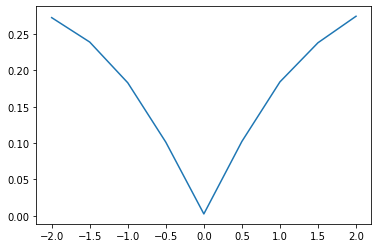

In [14]:
lmbdas = np.arange(-2,2.5,0.5)
swaptions1 = []
swaptions2 = []
for l in lmbdas:
    sim1 = simul(l,a,b,chi,T0,N,M,"Euler")
    swaptions1.append(swaption_MC(M,sim1,K,chi,bonds,maturities))
    #sim2 = simul_TM(l,a,b,chi,T0,TN,N,M)
    #swaptions2.append(swaption_MC_TM(M,sim2,K,chi,bonds,maturities))
#plot2D(lmbdas,swaptions1,"lambda","Risk neutral","Swaption Price",swaptions2,"Terminal")
plt.plot(lmbdas,swaptions1)

In [ ]:
lmbdas = np.arange(-2,2.5,0.5)
swaptions1 = []
swaptions2 = []
swaptions3 = []
swaptions4 = []
for l in lmbdas:
    sim1 = simul(l,a,b,chi,T0,N,M)
    swaptions1.append(swaption_MC(M,sim1,K,chi,bonds,maturities))
    sim2 = simul(l,a,b,chi,T0,N,M,"Euler")
    swaptions2.append(swaption_MC(M,sim2,K,chi,bonds,maturities))
    sim3 = simul(l,a,b,chi,T0,N,M,"Impli Euler")
    swaptions3.append(swaption_MC(M,sim3,K,chi,bonds,maturities))
    sim4 = simul(l,a,b,chi,T0,N,M,"Impli log-Euler")
    swaptions4.append(swaption_MC(M,sim4,K,chi,bonds,maturities))
plt.plot(lmbdas,swaptions1,label="Exp log-Euler")
plt.plot(lmbdas,swaptions2,label="Exp Euler")
plt.plot(lmbdas,swaptions3,label="Imp Euler")
plt.plot(lmbdas,swaptions4,label="Imp log-Euler")
plt.legend()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


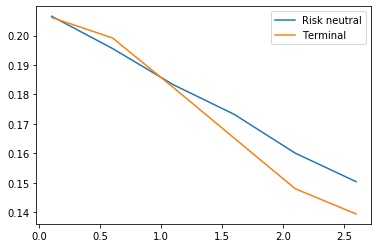

In [67]:
b_val = np.arange(0.1,3,0.5)
swaptions1 = []
swaptions2 = []
for bi in b_val:
    sim1 = simul(lmbda,a,bi,chi,T0,N,M,"Euler")
    swaptions1.append(swaption_MC(M,sim1,K,chi,bonds,maturities))
    sim2 = simul_TM(lmbda,a,bi,chi,T0,TN,N,M)
    swaptions2.append(swaption_MC_TM(M,sim2,K,chi,bonds,maturities))
plt.plot(b_val,swaptions1,label="Risk neutral")
plt.plot(b_val,swaptions2,label="Terminal")
plt.legend()
plt.show()

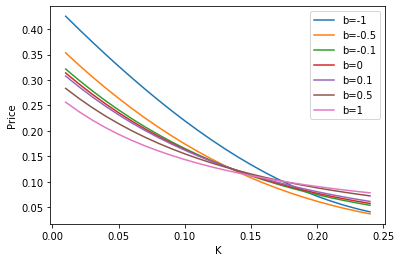

In [104]:
T0 = 1
strikes = np.arange(0.01,0.25,0.01)
maturities = np.arange(T0,T0+5.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
b_vals = [-1,-0.5,-0.1,0,0.1,0.5,1]
for b in b_vals:
    sim = simul(lmbda,a,b,chi,t,N,M,"Euler")
    Price = []
    for k in strikes:
        Price.append(swaption_MC(M,sim,k,chi,bonds,maturities))
    plt.plot(strikes,Price,label="b=" +str(b))
plt.xlabel("K")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
b_val = np.arange(0.1,3,0.1)
swaptions1 = []
swaptions2 = []
swaptions3 = []
swaptions4 = []
for bi in b_val:
    sim1 = simul(lmbda,a,bi,chi,T0,N,M)
    swaptions1.append(swaption_MC(M,sim1,K,chi,bonds,maturities))
    sim2 = simul(lmbda,a,bi,chi,T0,N,M,"Euler")
    swaptions2.append(swaption_MC(M,sim2,K,chi,bonds,maturities))
    sim3 = simul(lmbda,a,bi,chi,T0,N,M,"Impli Euler")
    swaptions3.append(swaption_MC(M,sim3,K,chi,bonds,maturities))
    sim4 = simul(lmbda,a,bi,chi,T0,N,M,"Impli log-Euler")
    swaptions4.append(swaption_MC(M,sim4,K,chi,bonds,maturities))
    if (bi%0.5==0):
        print(bi)
plt.plot(b_val,swaptions1,label="log-Euler")
plt.plot(b_val,swaptions2,label="Euler")
plt.plot(b_val,swaptions3,label="Imp Euler")
plt.plot(b_val,swaptions4,label="Imp log-Euler")
plt.legend()
plt.show()

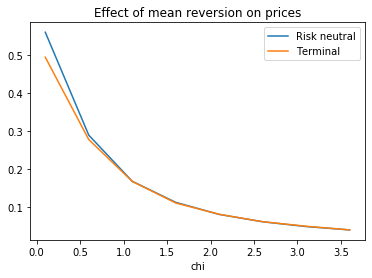

In [65]:
mean_reversion_val = np.arange(0.1,4,0.5)
swaptions1 = []
swaptions2 = []
for mr in mean_reversion_val:
    sim1 = simul(lmbda,a,b,mr,T0,N,M)
    swaptions1.append(swaption_MC(M,sim1,K,mr,bonds,maturities))
    sim2 = simul_TM(lmbda,a,b,mr,T0,TN,N,M)
    swaptions2.append(swaption_MC_TM(M,sim2,K,mr,bonds,maturities))

plot2D(mean_reversion_val,swaptions1,'chi','Risk neutral','Effect of mean reversion on prices',swaptions2,"Terminal")

In [ ]:
mean_reversion_val = np.arange(0.1,4,0.5)
swaptions1 = []
swaptions2 = []
swaptions3 = []
swaptions4 = []
for mr in mean_reversion_val:
    sim1 = simul(lmbda,a,b,mr,T0,N,M)
    swaptions1.append(swaption_MC(M,sim1,K,mr,bonds,maturities))
    sim2 = simul(lmbda,a,b,mr,T0,N,M,"Euler")
    swaptions2.append(swaption_MC(M,sim2,K,mr,bonds,maturities))
    sim3 = simul(lmbda,a,b,mr,T0,N,M,"Impli Euler")
    swaptions3.append(swaption_MC(M,sim3,K,mr,bonds,maturities))
    sim4 = simul(lmbda,a,b,mr,T0,N,M,"Impli log-Euler")
    swaptions4.append(swaption_MC(M,sim4,K,mr,bonds,maturities))
    
plt.plot(mean_reversion_val,swaptions1,label="log-Euler")
plt.plot(mean_reversion_val,swaptions2,label="Euler")
plt.plot(mean_reversion_val,swaptions3,label="Imp Euler")
plt.plot(mean_reversion_val,swaptions4,label="Imp log-Euler")
plt.legend()
plt.show()

**Remark:** One observes that the swaption volatility decreases as the mean reversion increases as it is said p. 553 in Piterbarg. Indeed, the mean reversion parameter tends to keep the factor x around a mean level

## 7. Implied volatility computation

### Log normal swap rate
Assume that the swap rate $S$ is log-normal. We have the following diffusion $$\mathrm{d}S_{T0,...,T_N}(t) = S_{T0,...,T_N}(t)\sigma \ \mathrm{d}W_t$$ because it has to be a martingale under $\mathbb{Q}^A$ where $$\frac{\mathrm{d}\mathbb{Q}^A}{\mathrm{d}\mathbb{Q}}\Big| _{\mathcal{F}_t} = \frac{A(t)}{A(0)} e^{-\int_{0}^{t} r(s) \ \mathrm{d}s}$$

Hence $$\begin{array}{ll} V_0 &= \mathbb{E}_{\mathbb{Q}}\Big[ e^{-\int_{0}^{t} r(s) \ \mathrm{d}s} Swap(T_0)^+ \Big]
= A(0) \mathbb{E}_{\mathbb{Q}^A}\Big[ \big(S(T_0) -K \big) \mathbb{1}_{S(T_0)>K} \Big] \end{array}$$

Let $$\frac{\mathrm{d}\tilde{\mathbb{Q}}}{\mathrm{d}\mathbb{Q}^A} = \frac{S(T_0)}{\mathbb{E}[S(T_0)]} = e^{-\frac{\sigma^2}{2}T_0 + \sigma W_{T_0}}$$ and by Girsanov's Theorem, $$\tilde{W}_t = W^A_t - \sigma t$$ is a Brownian motion under $\tilde{\mathbb{Q}}$.

Assume $S(0) > 0 , \ K > 0$.

It leads to a Black Scholes formula by:
$$\begin{array}{ll} V_0 &= A(0)S(0) \tilde{\mathbb{Q}} \Big(S(0) e^{\frac{\sigma^2}{2}T_0 + \sigma \tilde{W}_{T_0}} > K \Big) \ -K A(0) \mathbb{Q}^A \Big( \sigma W_{T_0} > \ln{\frac{K}{S(0)}} + \frac{\sigma^2}{2} T_0 \Big) \\
&= \boxed{A(0)S(0) \Phi(d^+) \ -KA(0) \Phi(d^-)}
\end{array}$$

$$\left\{
    \begin{array}{ll}
       d^+ &= \frac{\ln{\frac{S(0)}{K}} + \frac{\sigma^2}{2} T_0}{\sigma \sqrt{T_0}} \\
       d^- &= d^+ - \sigma \sqrt{T_0}
    \end{array}
\right.$$

In particular, $\frac{\partial d^+}{\partial \sigma} = \frac{\partial d^-}{\partial \sigma} + \sqrt{T_0}$ and 
$$vega = \frac{\partial V_0}{\partial \sigma} = A(0)S(0) \frac{\partial d^+}{\partial \sigma} \phi(d^+) \ -K A(0) \frac{\partial d^-}{\partial \sigma} \phi(d^-) \\
= A(0)S(0) \sqrt{\frac{T_0}{2\pi}} e^{-\frac{(d^+)^2}{2}}$$ ($\Phi$ is the cdf of the standard normal law and $\phi$ its density function.)

First view of Black scholes prices to be sure that the pricing formula is right and that the asymptotic behavior is the expected one, i.e $V_0 \rightarrow_{\sigma \to \infty} A(0)S(0)$ and $V_0 \rightarrow_{\sigma \to 0^+} A(0) (S(0)-K)^+$

**Cases:**
- $S_0 < 0 \ \& \ K>0 \quad \implies V_0 = 0$

- $ S_0 >0 \ \& \ K<0 \quad \implies V_0 = A(0) S(0) - K A(0)$

- $ S_0 < 0 \ \& \ K<0 \quad \implies V_0 = A(0)S(0) \tilde{\mathbb{Q}} \Big( e^{\frac{\sigma^2}{2}T_0 + \sigma \tilde{W}_{T_0}} < \frac{K}{S(0)} \Big) \ -K A(0) \mathbb{Q}^A \Big( e^{\frac{-\sigma^2}{2}T_0 + \sigma W^A_{T_0}} < \frac{K}{S(0)} \Big) = A(0)S(0) \Phi(-d^+) - K A(0) \Phi(-d^-)$

- If $S(0) = 0$ or $K=0$ or $\sigma=0$, one ends up with $V_0 = A(0) \big(S(0)-K \big) \mathbb{1}_{S(0)>K}$

lim_infty= 0.21573778880336414 lim_0 = 0.17312732826947502


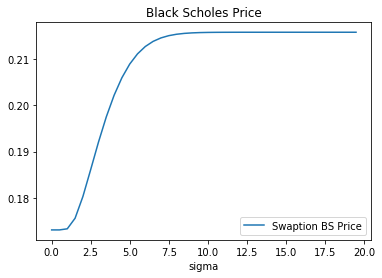

In [15]:
#Black Scholes Price

def Price_BS(S0,A0,T0,K,sigma):
    if (T0==0):
        return A0 * max(0,S0-K)
    elif(S0*K >0 and S0>0 and sigma>0):
        d = (np.log(S0/K) + 0.5*T0*sigma**2)/(sigma*np.sqrt(T0))
        return S0*A0* stats.norm.cdf(d) -K*A0*stats.norm.cdf(d-sigma*np.sqrt(T0))
    elif (S0*K >0 and S0<0 and sigma>0):
        d = (np.log(S0/K) + 0.5*T0*sigma**2)/(sigma*np.sqrt(T0))
        return S0*A0* stats.norm.cdf(-d) -K*A0*stats.norm.cdf(-d+sigma*np.sqrt(T0))
    else:
        return A0* max(0,S0-K)

T0 = maturities[0]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
sigma_val = np.arange(0,20,0.5)
BS_prices = [Price_BS(S0,A0,T0,0.01,s) for s in sigma_val]
lim_0 = A0*max(0,S0-0.01)
print('lim_infty=',S0*A0,'lim_0 =',lim_0)


plot2D(sigma_val,BS_prices,'sigma','Swaption BS Price','Black Scholes Price')

### Newton-Raphson algorithm

The simple Newton-Raphson algorithm, applied to find the zero of the function $\sigma \rightarrow V_0(\sigma) - \hat{V}$ where $\hat{V}$ is the observed marked to market value of the swaption, is written:

$$\left\{
    \begin{array}{ll}
       \sigma_0 \quad \text{chosen}\\
       \sigma_{n+1} = \sigma_n - \bigg( \frac{V_0(\sigma_n) - \hat{V}}{\frac{\partial V_0}{\partial \sigma}(\sigma_n)} \bigg)
    \end{array}
\right.$$

In [13]:
def Newton_Raphson(sigma0, nb_it, Mtm, bonds, K, maturities):
    sigma = sigma0
    T0 = maturities[0]   
    nb_maturities = maturities.size
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    
    for i in range(nb_it):
        d = (np.log(S0/K) + 0.5*T0*sigma**2)/(sigma*np.sqrt(T0))
        price_BS = (bonds[0]-bonds[-1])* stats.norm.cdf(d) -K*A0*stats.norm.cdf(d-sigma*np.sqrt(T0))
        derivative = (bonds[0]-bonds[-1])*np.sqrt(T0/(2*np.pi))*np.exp(-0.5*d**2)
        sigma = sigma - (price_BS-Mtm)/derivative
    return sigma

Newton_Raphson(1,4,0.05,bonds,0.05,maturities)

0.8154963284248895

There is some instability with the Newton-Raphson algorithm because the derivative of the Black Scholes price tends to be very small.

### Dichotomie

In [13]:
def bissectrice(nb_it, Mtm, bonds, K, maturities):
    T0 = maturities[0]   
    nb_maturities = maturities.size
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)

    x = 0
    y = 1
    for i in range(nb_it):
        z = (x+y)/2
        sigma = z/(1-z)
        price_BS = Price_BS(S0,A0,T0,K,sigma)

        if(Mtm > price_BS):
            x = z
        else:
            y = z
    z = (x+y)/2
    return z/(1-z)

bissectrice(10,0.05,bonds,0.05,maturities)

0.8139946855624446

### Root finding by Python's algorithm

In [3]:
# méthode bissectrice de Python

def biss_python(Mtm, bonds, K, maturities,model = "log-normal",b = 0.5):
    T0 = maturities[0] 
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    #Inversion in the log normal model
    if(model == "log-normal"):
        if(Mtm >= S0*A0):
            print("!! Le prix d'entrée est au-dessus des limites BS!!",Mtm, ">", S0*A0)
        if(Mtm < A0*max(0,S0-K)):
            print("!! Le prix d'entrée est en-dessous des limites BS!!", Mtm, "<", A0*max(0,S0-K))
        return opt.bisect(lambda x: round(Price_BS(S0,A0,T0,K,x) - Mtm,12), 0, 50)  #round to 10^-12 to avoid error caused by non significativ decimals
    
    #Inversion in the normal model
    if(model == "normal"):
        return opt.bisect(lambda x: swaption_normal(x,K,maturities,bonds) - Mtm, 0, 50) 
    
    #Inversion in the log-displaced model
    if(model == "log-displaced"):
        return opt.bisect(lambda x: log_displaced(x,b,K,maturities,bonds) - Mtm, 0.001,50)

In [16]:
#Brent's method

def Brent(Mtm, bonds, K, maturities):
    T0 = maturities[0] 
    nb_maturities = maturities.size
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    f = lambda x: Price_BS(S0,A0,T0,K,x) - Mtm
    return opt.brentq(f, 0.001, 20)


This algorithm is efficient but stops wether $f(a)f(b)>0$ at one moment

In [17]:
#Essai sur un prix BS avec sigma connu et comparaison des méthodes
chi = 1
sigma = 0.5
nb_maturities = maturities.size
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi) 
Market_price = Price_BS(S0,A0,T0,0.05,sigma)

New_vol = Newton_Raphson(0.1, 1, Market_price, bonds, 0.05, maturities)
bissec_vol = bissectrice(10, Market_price, bonds, 0.05, maturities)
python_vol = biss_python(Market_price,bonds,0.05,maturities)
Brent_vol = Brent(Market_price,bonds,0.05,maturities)
print("Vol BS:", sigma,"Implied vol Newton:",New_vol,"Implied vol Bissec:",bissec_vol,"Implied vol biss_python", python_vol,"Implied vol Brent: ",Brent_vol
)

Vol BS: 0.5 Implied vol Newton: 0.502698358977625 Implied vol Bissec: 0.5003663003663004 Implied vol biss_python 0.4999999999990462 Implied vol Brent:  0.5000000000000001


### Effect of K

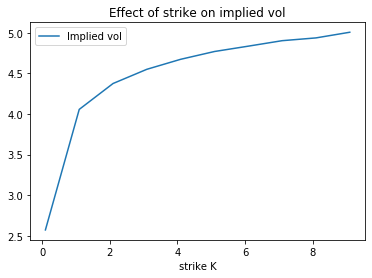

In [106]:
strikes = np.arange(0.1,10,1)
impli_vol = [bissectrice(10,0.1,bonds,k,maturities) for k in strikes]

plot2D(strikes,impli_vol,'strike K','Implied vol','Effect of strike on implied vol')

**Explanation:** One should have an implied volatility surface which is decreasing with respect to strike K, but this phenomenon is justified by the fact that input price is the same for all values of K and is 'randomly' chosen. Indeed Black & Scholes price is decreasing with respect to K: $$\frac{\partial V_0}{\partial K} = A(0)S(0) \frac{\partial d^+}{\partial K} \phi(d^+) \ -A(0)K \frac{\partial d^-}{\partial K} \phi(d^-) - A(0) \Phi(d^-)$$

And $\frac{\partial d^+}{\partial K} = \frac{\partial d^-}{\partial K} = \frac{-1}{\sigma \sqrt{T_0}K}$

So $$\frac{\partial V_0}{\partial K} = \frac{-A(0)}{\sigma\sqrt{T_0}} \Big( \frac{S(0)}{K}\phi(d^+)-\phi(d^+-\sigma\sqrt{T_0}) \Big) \ -A(0) \Phi(d^-) = -A(0) \Phi(d^-) \ \le 0$$

Hence if $K_1 \le K_2, \quad \hat{V} = V_0(K_1,\sigma_1) = V_0(K_2,\sigma_2)$ then $\sigma_2 \ge \sigma_1$ which explains the behavior of the curve above.

One should rather calculate the Monte Carlo Swaption Price for each strike instead of plotting the implied volatility calculated on a single Price

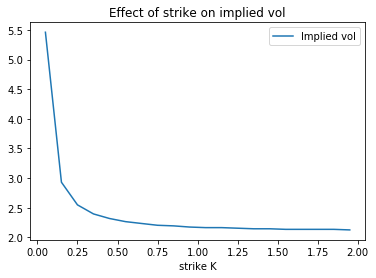

In [117]:
#MC(K) = BS(K,sigma)

sim = simul(lmbda,a,b,chi,T0,N,M)
strikes = np.arange(0.05,2,0.1)
implied_vol = []
for k in strikes:
    Price = swaption_MC(M,sim,k,chi,bonds,maturities)
    implied_vol.append(bissectrice(10,Price,bonds,k,maturities))

plot2D(strikes,implied_vol,'strike K','Implied vol','Effect of strike on implied vol')

**Remark:** Here one observes an implied volatility curve which is decreasing with respect to the strike K as expected. However no smile phenomenon is remarkable here and higher values of the strike implies more unstability in the inversion algorithm and the observations would have no sense.

### Effect of T0

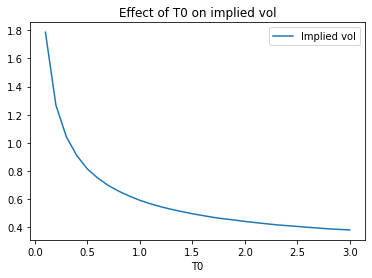

In [34]:
T0s = np.arange(0.1,3.1,0.1)
impli_vol = [bissectrice(10,0.05,[np.exp(-r*m) for m in np.arange(t,t + 5.5,0.5)],K,np.arange(t,t + 5.5,0.5)) for t in T0s]

plot2D(T0s,impli_vol,'T0','Implied vol','Effect of T0 on implied vol')

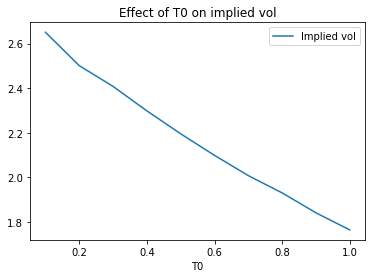

In [35]:
# MC(T0) = BS(T0,sigma)
T0s = np.arange(0.1,1.1,0.1)
implied_vol = []
for T in T0s:
    sim = simul(lmbda,a,b,chi,T,N,M)
    tenor = np.arange(T,T+ 5.5,0.5)
    bonds = [np.exp(-r*m) for m in tenor]
    Price = swaption_MC(M,sim,0.5,chi,bonds,tenor)
    implied_vol.append(bissectrice(10,Price,bonds,0.5,tenor))
    
plot2D(T0s,implied_vol,'T0','Implied vol','Effect of T0 on implied vol')

**Remark:** The volatility surface observed in the market is in general decreasing with respect to the maturity, as we can observe here

### Reliability of bissection method
One will input a swaption price calculated by the Black & Scholes formula for a known volatility. The generated surface is then supposed to be flat and equal to this level of volatility. It is a way to check if the inversion method is unstable somewhere. $$V_0^{BS}(T0,K,\sigma) = \hat{V}$$

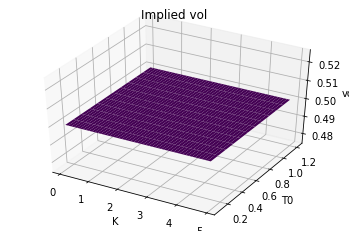

In [17]:
#from a BS price with sigma known --> flat curve in theory
T0s = np.arange(0.1,1.3,0.1)
strikes = np.arange(0.1,5,0.1)
X,Y = np.meshgrid(strikes, T0s)
sigma = 0.5
Z = np.zeros((T0s.size,strikes.size))
i,j= 0,0
for t in T0s:
    maturities = np.arange(t,t+5.5,0.5)
    bonds = [np.exp(-r*m) for m in maturities]
    nb_maturities = maturities.size
    A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
    S0 = (bonds[0]-bonds[-1])/A0
    for k in strikes: 
        Price = Price_BS(S0,A0,t,k,sigma)
        vol = bissectrice(10,Price, bonds, k, maturities)
        Z[i][j] = vol
        j = (j+1)%strikes.size
    i+=1
        
plot3D(X,Y,Z,300)

**Remark:** It can be osbserved that the implied volatility surface is flat almost everywhere. However implied volatility seems to vanish for low levels of $K$ and $T_0$. The lower the input volatility is, the more important is the unstability.

Now one will inverse a price given by the Monte Carlo method described before. $$V_0^{BS}(T0,K,\sigma) = V_0^{MC}(T_0,K)$$

## 8. Implied Volatility surface building

### a.Normal model
$$\mathrm{d}S(t) = \sigma \mathrm{d}W(t)$$

$$V_0^N = A(0) \big[ (S(0)-K) \Phi(d) + \sigma \sqrt{T} \phi(d) \big], \\ d = \frac{S(0)-K}{\sigma \sqrt{T}}$$

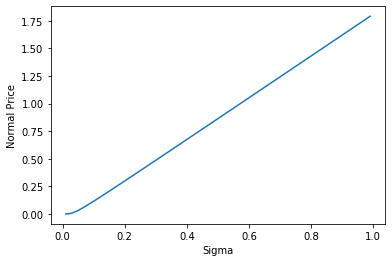

In [30]:
# Implied vol. surface for normal model dSt = sigma*dWt

def swaption_normal(sigma,K,maturities,bonds):
    T = maturities[0]
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    if (sigma==0):
        return -K * A0 * int( K < 0)
    else:
        d = (S0-K)/(sigma*np.sqrt(T))
        return A0*((S0-K)*stats.norm.cdf(d) + sigma*np.sqrt(T)*gaussian_density(d))

vol = np.arange(0.01,1,0.01)
maturities = np.arange(1,6.5,0.5)
bonds = ZC[2:13]
normal_prices = [swaption_normal(v,0.05,maturities,bonds) for v in vol]
plt.plot(vol,normal_prices)
plt.ylabel("Normal Price")
plt.xlabel("Sigma")
plt.show()

In [37]:
T = 1
maturities = np.arange(T,T + 5.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
strikes = np.arange(0.01,0.3,0.01)
sim = simul(lmbda,a,b,chi,t,N,M,"Euler")
for k in strikes:
    print(swaption_MC(M,sim,k,chi,bonds,maturities))

0.36260283482580097
0.3597850580777045
0.3569672813296097
0.3541495045815146
0.35133172783342637
0.34851395108533406
0.3456961743372406
0.3428783975891508
0.3400606208410584
0.33724284409296384
0.33442506734487326
0.331607290596778
0.32878951384868293
0.3259717371005952
0.32315396035250377
0.3203361836044135
0.31751840685631383
0.31470063010822497
0.31188285336013294
0.3090650766120404
0.30624729986394855
0.303429523115862
0.30061174636776716
0.2977939696196741
0.29497619287158067
0.2921584161234927
0.28934063937539606
0.2865228626273025
0.2837050858792101


As we can see, prices in the normal model are not bounded. By inverting prices in this model instead of the log normal model there shouldn't have any problem of inversion in theory. It is therefore a good benchmark to check if the inversion method is correct or not.

In [46]:
# IV vol. surface in normal model

strikes = np.arange(0.01,0.3,0.01)
T0s = np.arange(0.5,3,0.5)
X,Y = np.meshgrid(strikes, T0s)
surface = np.zeros((T0s.size,strikes.size))
i,j= 0,0
compteur = 0
for t in T0s:
    sim = simul(lmbda,a,b,chi,t,N,M,"Euler")
    maturities = np.arange(t,t + 5.5,0.5)
    #bonds = ZC[int(t*2):int(2*t+11)]
    bonds = [np.exp(-r*m) for m in maturities]
    for k in strikes:
        Price = swaption_MC(M,sim,k,chi,bonds,maturities)
        #surface[i][j] = bissectrice(10,Price, bonds, k, maturities)
        surface[i][j] = biss_python(Price,bonds,k,maturities,"normal")
        j = (j+1)%strikes.size
        compteur +=1
    i+=1
    print(compteur*100/(T0s.size*strikes.size),'%')

20.0 %
40.0 %
60.0 %
80.0 %
100.0 %


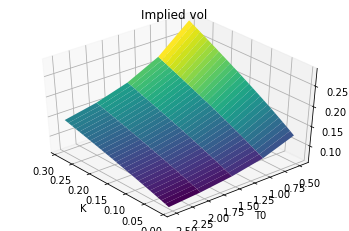

In [47]:
plot3D(X,Y,surface,140)

**Implied volatitlity increasing with respect to K?**

$$\frac{\partial SwaptionMC(K)}{\partial K} \le 0, \\ \frac{\partial V_0}{\partial \sigma} = A(0) \sqrt{T} \phi(d) \ge 0$$

One let $T_0$.

$$V_0(\sigma_{Imp}(K),K) = SwaptionMC(K)$$

By differentiating that equation, one has $$\frac{\partial \sigma_{Imp}(K)}{\partial K} = \frac{\Big(\frac{\partial SwaptionMC(K)}{\partial K} - \frac{\partial V_0(\sigma_{Imp}(K),K)}{\partial K}\Big)}{\frac{\partial V_0(\sigma_{Imp}(K),K)}{\partial \sigma}}. \tag{*}$$ That quantitie has the same sign as its numerator. For this reason, the slope of the implied volatility with respect to K can be negative if the slope of the Monte Carlo price is not as strong as the slope of the pricing function in the normal model.

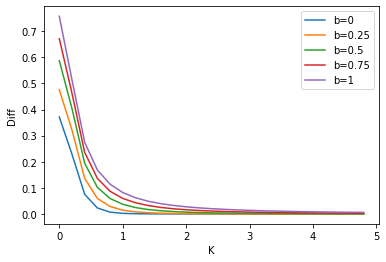

In [72]:
#Sign of the derivative in K of the IV int the normal model
strikes = np.arange(0,5,0.2)
T0 = 1
epsilon = 0.05
maturities = np.arange(T0,T0+5.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
b_vals = [0,0.25,0.5,0.75,1]

for b in b_vals:
    sim = simul(lmbda,a,b,chi,T0,N,M,"Euler")
    diff = []
    for k in strikes:
        d_MCPrices = (swaption_MC(M,sim,k+0.5*epsilon,chi,bonds,maturities) - swaption_MC(M,sim,k-0.5*epsilon,chi,bonds,maturities))/epsilon
        sigma_imp = biss_python(swaption_MC(M,sim,k,chi,bonds,maturities),bonds,k,maturities,"normal")
        d = (S0-k)/(sigma_imp * np.sqrt(T0))
        diff.append(d_MCPrices + A0 * stats.norm.cdf(d))
    plt.plot(strikes,diff,label="b=" + str(b))
plt.xlabel('K')
plt.ylabel('Diff')
plt.legend()
plt.show()

Here on notes $$Diff = \Big(\frac{\partial SwaptionMC(K)}{\partial K} - \frac{\partial V_0(\sigma_{Imp}(K),K)}{\partial K}\Big)$$ and $$sign(Diff) = sign(\frac{\partial \sigma_{Imp}(K)}{\partial K})$$

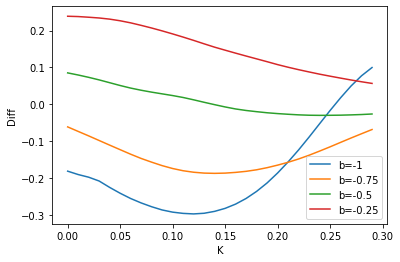

In [82]:
#Sign of the derivative in K of the IV int the normal model (for b <0)
strikes = np.arange(0,0.30,0.01)
T0 = 1
epsilon = 0.05
maturities = np.arange(T0,T0+5.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
b_vals = [-1,-0.75,-0.5,-0.25]

for b in b_vals:
    sim = simul(lmbda,a,b,chi,T0,N,M,"Euler")
    diff = []
    for k in strikes:
        d_MCPrices = (swaption_MC(M,sim,k+0.5*epsilon,chi,bonds,maturities) - swaption_MC(M,sim,k-0.5*epsilon,chi,bonds,maturities))/epsilon
        sigma_imp = biss_python(swaption_MC(M,sim,k,chi,bonds,maturities),bonds,k,maturities,"normal")
        d = (S0-k)/(sigma_imp * np.sqrt(T0))
        diff.append(d_MCPrices + A0 * stats.norm.cdf(d))
    plt.plot(strikes,diff,label="b=" + str(b))
plt.xlabel('K')
plt.ylabel('Diff')
plt.legend()
plt.show()

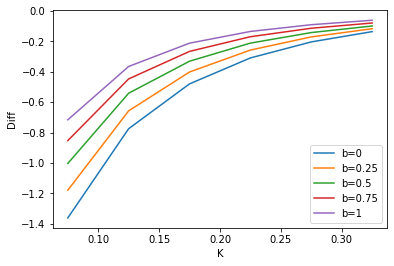

In [84]:
#Sign of the derivative in K of the IV int the log-normal model
strikes = np.arange(0.075,0.35,0.05)
T0 = 1
epsilon = 0.05
maturities = np.arange(T0,T0+5.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
b_vals = [0,0.25,0.5,0.75,1]

for b in b_vals:
    sim = simul(lmbda,a,b,chi,T0,N,M,"Euler")
    diff = []
    for k in strikes:
        d_MCPrices = (swaption_MC(M,sim,k+0.5*epsilon,chi,bonds,maturities) - swaption_MC(M,sim,k-0.5*epsilon,chi,bonds,maturities))/epsilon
        sigma_imp = biss_python(swaption_MC(M,sim,k,chi,bonds,maturities),bonds,k,maturities)
        d = (np.log(S0/k)- 0.5 * sigma_imp**2 * T0)/(sigma_imp * np.sqrt(T0))
        diff.append(d_MCPrices + A0 * stats.norm.cdf(d))
    plt.plot(strikes,diff,label="b=" + str(b))
plt.xlabel('K')
plt.ylabel('Diff')
plt.legend()
plt.show()

**Conclusion:** On these three last graphs, one can see the so called 'Diff' value with respect to the strike K. The computed value 'Diff' represents an approximation of the numerator in $(*)$ (the derivative of the function $SwaptionMC(\cdot)$ is approximated by centered finite difference). 

The implied volatility in the normal model has indeed a positive slope as $b \ge 0$ which can become negative as $b <0$ contrary to the implied volatility in the log-normal model which seems to have the opposite behavior. 

### IV surface with log-displaced model prices

In [120]:
# plot of the implied volatility surface with log-displaced Prices as input prices

strikes = np.arange(0.05,2,0.1)
T0s = np.arange(0.1,1.1,0.1)
X,Y = np.meshgrid(strikes, T0s)
surface = np.zeros((T0s.size,strikes.size))
i,j= 0,0
compteur = 0
for t in T0s:
    maturities = np.arange(t,t+5.5,0.5)
    bonds = [np.exp(-r*m) for m in maturities]
    sim = simul(lmbda,a,b,chi,t,N,M,"Euler")
    for k in strikes:
        Price = log_displaced(1,0.5,k,maturities,bonds)  #log-displaced price with sigma=1, b=0.5
        surface[i][j] = biss_python(Price,bonds,k,maturities,"normal")
        j = (j+1)%strikes.size
        compteur +=1
    i+=1
    print(compteur*100/(T0s.size*strikes.size),'%')

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %


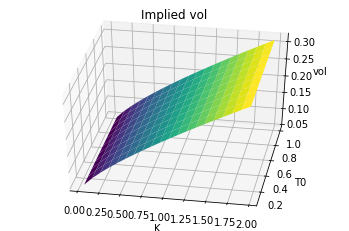

In [121]:
plot3D(X,Y,surface,-80)

### b.Quasi gaussian model

In [19]:
#construction of an implied volatility surface

def construct_surface(strikes,T0s,M,N,lmbda,a,b,chi,scheme="Euler",model = "log-normal"):
    surface = np.zeros((T0s.size,strikes.size))
    i,j= 0,0
    compteur = 0
    for t in T0s:
        maturities = np.arange(t,t+5.5,0.5)
        #bonds = ZC[int(t*2):11]
        bonds = [np.exp(-r*m) for m in maturities]
        sim = simul(lmbda,a,b,chi,t,N,M,scheme)
        for k in strikes:
            Price = swaption_MC(M,sim,k,chi,bonds,maturities)
            #surface[i][j] = bissectrice(10,Price, bonds, k, maturities)
            surface[i][j] = biss_python(Price,bonds,k,maturities,model)
            j = (j+1)%strikes.size
            compteur +=1
        i+=1
        print(compteur*100/(T0s.size*strikes.size),'%')
    return surface

### c.Region of failure

In [30]:
#print the values of (T0,K) for which the MC price of the swaption is above the BS limit
strikes = np.arange(0.01,0.25,0.01)
T0s = np.arange(0.5,3,0.5)
prices = np.zeros((T0s.size,strikes.size))
i,j=0,0
for t in T0s:
    maturities = np.arange(t,t+5.5,0.5)
    bonds = [np.exp(-r*m) for m in maturities]
    #bonds = ZC[int(2*t):int(2*t)+11]
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    sim = simul(lmbda,a,b,chi,t,N,M,"Euler")
    
    for k in strikes:
        Price = swaption_MC(M,sim,k,chi,bonds,maturities)
        prices[i][j] = Price
        if (A0*S0 - Price <=0):
            print(t,k,"!! / ! \ !! Prix au dessus des limites BS", A0*S0-Price)
        if (A0*max(S0-k,0) - Price >=0):
            print(t,k,"!! / ! \ !! Prix en dessous des limites BS", A0*max(S0-k,0)-Price) 
        j = (j+1)%strikes.size
    i+=1

0.5 0.01 !! / ! \ !! Prix au dessus des limites BS -0.03704695802905095
0.5 0.02 !! / ! \ !! Prix au dessus des limites BS -0.016773272972542053
1.0 0.01 !! / ! \ !! Prix au dessus des limites BS -0.04662809203543644
1.0 0.02 !! / ! \ !! Prix au dessus des limites BS -0.028204533078422495
1.0 0.03 !! / ! \ !! Prix au dessus des limites BS -0.011711773371678141
1.5 0.01 !! / ! \ !! Prix au dessus des limites BS -0.04789996212268577
1.5 0.02 !! / ! \ !! Prix au dessus des limites BS -0.030146674525061312
1.5 0.03 !! / ! \ !! Prix au dessus des limites BS -0.014229693996261394
2.0 0.01 !! / ! \ !! Prix au dessus des limites BS -0.04839347363611887
2.0 0.02 !! / ! \ !! Prix au dessus des limites BS -0.031119579177644907
2.0 0.03 !! / ! \ !! Prix au dessus des limites BS -0.015626929564655917
2.0 0.04 !! / ! \ !! Prix au dessus des limites BS -0.0017324770028794845
2.5 0.01 !! / ! \ !! Prix au dessus des limites BS -0.04656035896286356
2.5 0.02 !! / ! \ !! Prix au dessus des limites BS -0.0

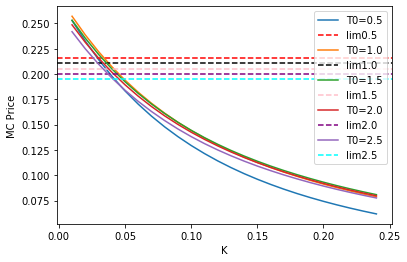

In [31]:
colors=['r','black','pink','purple','cyan']
for i in range(len(T0s)):
    t = T0s[i]
    maturities = np.arange(t,t+5.5,0.5)
    bonds = [np.exp(-r*m) for m in maturities]
    #bonds = ZC[int(2*t):int(2*t)+11]
    limit = S(0,0,0,maturities,bonds,1,chi)*A(0,0,0,maturities,bonds,1,chi)
    plt.plot(strikes,prices[i],label="T0="+str(t))
    plt.axhline(y=limit, color=colors[i] ,linestyle='--',label="lim" + str(t))
plt.xlabel("K")
plt.ylabel("MC Price")
plt.legend()
plt.show()

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %


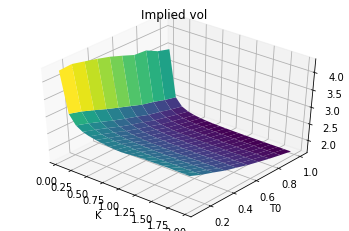

In [65]:
# plot of the implied volatility surface with Monte Carlo Prices as input prices

strikes = np.arange(0.05,2,0.1)
T0s = np.arange(0.1,1.1,0.1)
X,Y = np.meshgrid(strikes, T0s)
Z = construct_surface(strikes,T0s,M,N,lmbda,a,b,chi)
        
plot3D(X,Y,Z,-50)  

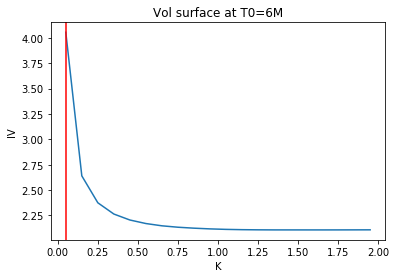

In [66]:
plt.plot(strikes,Z[4])
plt.xlabel("K")
plt.ylabel("IV")
plt.title("Vol surface at T0=6M")
maturities = np.arange(0.5,6,0.5)
ATM = S(0,0,0,maturities,[np.exp(-r*m) for m in maturities],1,chi)
plt.axvline(ATM, 0, 1, label='pyplot vertical line',color='r')
plt.show()

In [49]:
# Compute the IV where it fails with different Euler simulation
u = [1.7,1.8,1.9]
maturities = np.arange(0.1,5.6,0.5)
bonds = [np.exp(-r*m) for m in maturities]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
for i in range(5):
    print("Step" + str(i))
    sim = simul(lmbda,a,b,chi,0.1,N,M)   # M=100 000 simulations
    for stk in u:
        Price = swaption_MC(M,sim,stk,chi,bonds,maturities)
        iv = biss_python(Price,bonds,stk,maturities)
        if (A0*max(S0-k,0) - Price >=0):
            print("Limite dépassée")
        else:
            print("OK")

Step0
!! Le prix d'entrée est en-dessous des limites BS!! 0.0 < 0.0
Limité dépassée
!! Le prix d'entrée est en-dessous des limites BS!! 0.0 < 0.0
Limité dépassée
!! Le prix d'entrée est en-dessous des limites BS!! 0.0 < 0.0
Limité dépassée
Step1
OK
OK
OK
Step2
!! Le prix d'entrée est en-dessous des limites BS!! 0.0 < 0.0
Limité dépassée
!! Le prix d'entrée est en-dessous des limites BS!! 0.0 < 0.0
Limité dépassée
!! Le prix d'entrée est en-dessous des limites BS!! 0.0 < 0.0
Limité dépassée
Step3
!! Le prix d'entrée est en-dessous des limites BS!! 0.0 < 0.0
Limité dépassée
!! Le prix d'entrée est en-dessous des limites BS!! 0.0 < 0.0
Limité dépassée
!! Le prix d'entrée est en-dessous des limites BS!! 0.0 < 0.0
Limité dépassée
Step4
OK
OK
!! Le prix d'entrée est en-dessous des limites BS!! 0.0 < 0.0
Limité dépassée


**Conclusion:** One can see that depending on the Euler simulation, the Implied Vol. can be computed or not. One deduces that the problem comes from the Euler scheme.

### Issues: 

- Discretization schemes allow diffusion of $x$ to go to infinity very fast as $T_0$ increases. That produces overflow in the algorithm computation. To tackle this issue, one needs to set a barrier the diffusion can't reach. Here, one chose $10^{10}$.

- Prices tend to drop suddenly to zero as $K$ increases. A solution is to reduce the discretization step in the Euler scheme.

- Monte Carlo prices overcome the highest value reachable by the Black & Scholes model as $K$ takes low values. This problem is due to the model and is only solved by computing the implied volatility in the normal or displaced log-normal model.

### d.ATM prices

In [141]:
T0s = np.arange(0.5,3.5,0.5)
for i in range(T0s.size):
    T = T0s[i]
    swap_dates = np.arange(T,T+ 5.5,0.5) #tenor of the swaption between T0 and 5Y
    bonds = [np.exp(-r*m) for m in swap_dates]
    print("ATM Price for T0=",T,"Y: ", S(0,0,0,swap_dates,bonds,1,chi) )

ATM Price for T0= 0.5 Y:  0.05063024104885767
ATM Price for T0= 1.0 Y:  0.05063024104885769
ATM Price for T0= 1.5 Y:  0.05063024104885767
ATM Price for T0= 2.0 Y:  0.05063024104885766
ATM Price for T0= 2.5 Y:  0.05063024104885768
ATM Price for T0= 3.0 Y:  0.05063024104885767


Indeed if $\tau_n \equiv \tau$, here 0.5, and one let $P(0,t) = e^{-rt}$, one has:
$$\begin{array}{ll} S(0) &= \frac{1}{\tau} \frac{e^{-rT_0}-e^{-r T_N}}{\sum_{n=0}^{N-1} e^{-r(T_0+\tau(n+1))}} \\
&= \frac{1}{\tau} \frac{1-e^{-r (T_N-T_0)}}{\sum_{n=1}^{N} (e^{-r\tau})^n} \\
&= \frac{1}{\tau} \big( e^{\tau r} - 1 \big)
\end{array}$$

### e. An other surface building

**Idea:** One can observe some anomalies in the region around $(T_0,K) = (0.2 Y, 0.5)$ which could be generated by the random simulation made during the pricing step. Indeed with this version of the algorithm, one has generated $M$ samples of $(x,y,I)$ for each point of the grid. Even with a high value of $M$, differences could happen, that's why one would prefer to generate only one time $M$ samples of $(x,y,I)$ and do the Monte Carlo pricing with these samples for each point of the grid.


In [98]:
#One simulate a unique time M samples (x,y,I)

def simul2(x0,y0,I0,lmbda,a,b,chi,delta):
    N = delta.size
    (x,y,I) =(x0,y0,I0)
    for i in range(N-1):
        delta_i = delta[i+1]-delta[i]
        sigma_i = lmbda*(a+b*x)
        Z = float(np.random.standard_normal(1))
        I = I - x*delta_i
        x = x +(y-chi*x)*delta_i + sigma_i*math.sqrt(delta_i)*Z
        y = y + (sigma_i**2 -2*chi*y)*delta_i
    return [x,y,I]

def MC(M,sim,K,chi,bonds,maturities,exec_time=False):
    Monte_Carlo = 0
    for m in range(M):
        (x,y,I) = (sim[m][0],sim[m][1],sim[m][2])
        Monte_Carlo += np.exp(I)*payoff_swaption(maturities,bonds,x,y,chi,K)
        
    return Monte_Carlo/M

def construct_surface2(strikes,T0s,M,N,lmbda,a,b,chi):
    surface = np.zeros((T0s.size,strikes.size))
    sim = [(0,0,0)] * M
    i,j= 0,0
    for t in T0s:
        if i==0:
            delta = np.linspace(0,t,N+1)
        else:
            delta = np.linspace(T0s[i-1],T0s[i],N+1)
            
        sim = [simul2(sim[m][0],sim[m][1],sim[m][2],lmbda,a,b,chi,delta) for m in range(M)]
        maturities = np.arange(t,t+5.5,0.5)
        bonds = [np.exp(-r*m) for m in maturities]
        for k in strikes:
            Price = MC(M,sim,k,chi,bonds,maturities)
            surface[i][j] = bissectrice(10,Price, bonds, k, maturities)
            j = (j+1)%(strikes.size)
        i+=1
    return surface

In [68]:
t1=time()
strikes = np.arange(0.1,2,0.1)
T0s = np.arange(0.1,1.1,0.1)
X,Y = np.meshgrid(strikes, T0s)
Z = construct_surface2(strikes,T0s,M,N,lmbda,a,b,chi)
t2=time()
print("Exec time:",t2-t1)

Exec time: 492.00112795829773


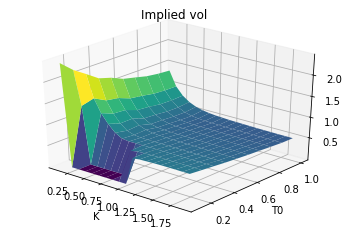

In [69]:
plot3D(X,Y,Z,-50)

### f.Skew

In [63]:
T0s = np.arange(0.5,3.5,0.5)
#Build the curve (T0,skew ATM)
def skew_curve(T0s,lmbda,a,b,chi):
    skew = np.zeros(T0s.size)
    for i in range(T0s.size):
        T0 = T0s[i]
        swap_dates = np.arange(T0,T0+5.5,0.5) # underlaying swap dates between T0 and T0+5Y
        bonds = [np.exp(-r*m) for m in swap_dates]
        sim = simul(lmbda,a,b,chi,T0,N,M)
        ATM = 0.25  # Calcul du skew en K=0.25 car en dehors des limites BS en S0
        #ATM = S(0,0,0,swap_dates,bonds,1,chi)# ATM rate = S0
        Price_95 = swaption_MC(M,sim,0.95*ATM,chi,bonds,swap_dates) #Swaption Price at 95% of the ATM strike
        Price_105 = swaption_MC(M,sim,1.05*ATM,chi,bonds,swap_dates) #Swaption Price at 105% of the ATM strike
        skew[i] = (biss_python(Price_105,bonds,1.05*ATM,maturities) - biss_python(Price_95,bonds,0.95*ATM,maturities))/(0.1*ATM)
        #skew[i] = (bissectrice(10,Price_105, bonds, 1.05*ATM, swap_dates) - bissectrice(10,Price_95, bonds, 0.95*ATM, swap_dates))/(0.1*ATM)
    return skew

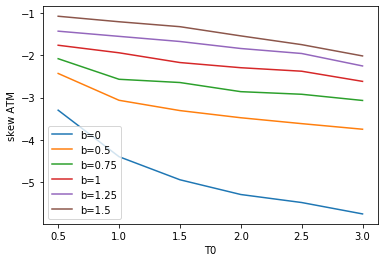

In [65]:
#skew ATM with respect to T0
plt.figure()
for b in [0,0.5,0.75,1,1.25,1.5]:
    plt.plot(T0s,skew_curve(T0s,lmbda,a,b,chi),label="b="+str(b))
plt.legend()
plt.xlabel("T0")
plt.ylabel("skew ATM")
plt.show()

In [66]:
# skew at fixed T0 with respect to K

T0 = 0.5
strikes = np.arange(0.4,2.6,0.2)
tenor = np.arange(T0,T0+5.5,0.5)
bonds = [np.exp(-r*m) for m in tenor]
sim = simul(lmbda,a,b,chi,T0,N,M)
skew = []
for k in strikes:
    Price_95 = swaption_MC(M,sim,0.95*k,chi,bonds,tenor)
    Price_105 = swaption_MC(M,sim,1.05*k,chi,bonds,tenor)
    slope = (bissectrice(10,Price_105, bonds, 1.05*k, tenor) - bissectrice(10,Price_95, bonds, 0.95*k, tenor))/(0.1*k)
    skew.append(slope)

In [67]:
T0 = 1
strikes = np.arange(0.4,2.6,0.2)
tenor = np.arange(T0,T0+5.5,0.5)
bonds = [np.exp(-r*m) for m in tenor]
sim = simul(lmbda,a,b,chi,T0,N,M)
skew2 = []
for k in strikes:
    Price_95 = swaption_MC(M,sim,0.95*k,chi,bonds,tenor)
    Price_105 = swaption_MC(M,sim,1.05*k,chi,bonds,tenor)
    slope = (bissectrice(10,Price_105, bonds, 1.05*k, tenor) - bissectrice(10,Price_95, bonds, 0.95*k, tenor))/(0.1*k)
    skew2.append(slope)

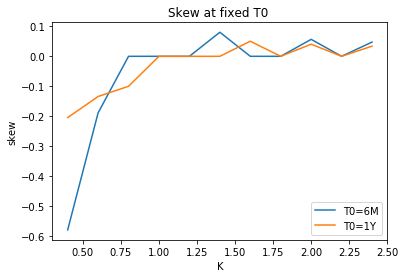

In [68]:
plt.figure()
plt.plot(strikes,skew,label="T0=6M")
plt.plot(strikes,skew2,label="T0=1Y")
plt.title("Skew at fixed T0 ")
plt.legend()
plt.xlabel("K")
plt.ylabel("skew")
plt.show()

One deduces from this curve that for a fixed swaption maturity $T_0$, the slope of the implied volatility is negative until $K \approx 1$ then there is a positive slope which seems to tend to zero when $K$ takes high values. This confirms the convex shape of the implied volatility with respect to strikes.

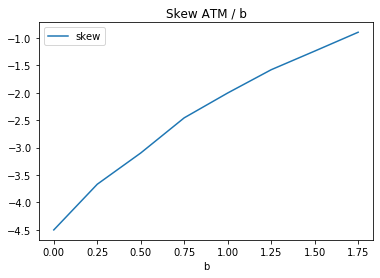

In [69]:
# T0 fixed, skew ATM with respect to b
b_vals = np.arange(0,2,0.25)
skew = [skew_curve(np.array([T0]),lmbda,a,b,chi) for b in b_vals]
plot2D(b_vals,skew,"b","skew","Skew ATM / b")

The slope of the implied volatility seems to be increasing in $b$ and its curvature tends to reduce with b.

### g.Displaced log normal swap rate

Assume that the swap rate follows the following dynamic under $\mathbb{Q}^A$ $$\begin{array}{ll} \mathrm{d}S(t) &= \sigma \big( bS(t) + (1-b)S(0) \big) \ \mathrm{d}W^A(t) \\ &= \sigma \big( bS(t) + \beta \big) \ \mathrm{d}W^A(t) \end{array}$$

If $U(t) = b S(t) + \beta$, one has $$\mathrm{d}U(t) = b \mathrm{d}S(t) = b \sigma U(t) \ \mathrm{d}W^A(t)$$ 
Hence $$\boxed{U(T) = U(t) e^{b \sigma ( W^A_T - W^A_t) - \frac{b^2 \sigma^2}{2}(T-t)}}$$

Equivalently $$\boxed{S(T) = -\frac{(1-b)}{b} S(0) + \frac{S(0)}{b} e^{b \sigma  W^A_T - \frac{b^2 \sigma^2}{2}T}}$$

In this framework, $$V_{swaption}(t) = A(t) \mathbb{E}\Big[\Big( S(T_0)-K \Big)^+ \Big | \mathcal{F}_t]$$

By variable change and Black Scholes formula, if $S(t)+\frac{1-b}{b}S(0) > 0$ and $K+\frac{1-b}{b}S(0)$ it yields 

$$\boxed{V_{swaption}(t) = A(t) \Big( \big(S(t)+\frac{1-b}{b}S(0) \big) \Phi(d^+) - \big(K+ \frac{1-b}{b}S(0)\big) \Phi(d^-) \Big) \\
d^{+/-} = \frac{\ln{\big( \frac{bS(t) + (1-b)S(0)}{bK+(1-b)S(0)}\big)} +_{/-} \frac{\sigma^2 b^2}{2}(T_0-t)}{\sigma b \sqrt{T_0-t}}}$$

Cases:

- If $S(0)- K < \frac{S(0)}{b} < 0$: $V_0 = 0$

- If $0 < \frac{S(0)}{b} < S(0)-K$ : $V_0 = A(0) (S(0)-K)$

- If $\frac{S(0)}{b} <0$ and $K + \frac{1-b}{b} S(0) <0$: $V_0 = A(0) \frac{S(0)}{b} \Phi(- d^+) - A(0) ( K + \frac{1-b}{b}S(0) ) \Phi(-d^-)$

- If $S(0) = 0$: $V_0 = -K A(0) \mathbb{1}_{K < 0}$

In [4]:
sigma = 1
b = 0.5
def log_displaced(sigma,b,K,maturities,bonds):
    T = maturities[0]
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    if(T==0):
        return A0 * max(0,S0 - K)
    
    if b==0:
        d = (S0-K)/(sigma*S0*np.sqrt(T))
        return A0 * (S0-K) * stats.norm.cdf(d) + A0 * sigma * S0 * np.sqrt(T) * gaussian_density(d)
    
    d = (np.log(S0/(b*K+(1-b)*S0)) + 0.5*sigma**2 * b**2 * T)/(sigma*b*np.sqrt(T))
    return A0*S0/b * stats.norm.cdf(d) - A0*(K+(1-b)/b *S0) * stats.norm.cdf(d - sigma*b*np.sqrt(T))

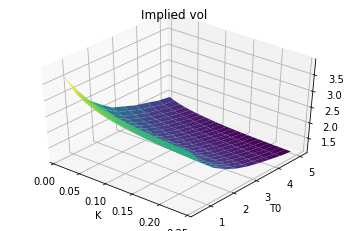

In [105]:
strikes = np.arange(0.01,0.25,0.01)
T0s = np.arange(0.5,5.5,0.5)
IV = np.zeros((T0s.size,strikes.size))
i,j= 0,0
for t in T0s:
    maturities = np.arange(t,t+5.5,0.5)
    bonds = [np.exp(-r*m) for m in maturities]
    sim = simul(lmbda,a,b,chi,t,N,M,"Euler")
    for k in strikes:
        Price = swaption_MC(M,sim,k,chi,bonds,maturities)
        #print(t,k,A0_obs(maturities,bonds)*S0_obs(maturities,bonds)-Price)
        #IV[i][j] = bissectrice(10,Price, bonds, k, maturities)
        IV[i][j] = biss_python(Price, bonds, k, maturities,"log-displaced",b)
        j = (j+1)%strikes.size
    i+=1
    
X,Y = np.meshgrid(strikes, T0s)
plot3D(X,Y,IV,-50)

lim_0= 0.0175380958495456 lim_infty= 0.13010907719201392


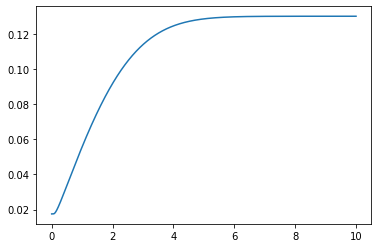

In [20]:
#Plot of the log displaced price for sigma
k = 0.01
vol = np.arange(0.001,10,0.001)
maturities = np.arange(1,6.5,0.5)
bonds = ZC[2:13]
S0 = S(0,0,0,maturities,bonds,1,chi)
A0 = A(0,0,0,maturities,bonds,1,chi)
print("lim_0=",A0*max(S0-k,0),"lim_infty=",A0*S0/b)
log_displaced_price = [log_displaced(v/b,b,k,maturities,bonds) for v in vol]
plt.plot(vol,log_displaced_price)
plt.show()

In [87]:
#print the values of (T0,K) for which the log displaced price of the swaption is above the BS limit
strikes = np.arange(0.01,0.3,0.01)
T0s = np.arange(0.5,5.5,0.5)

for t in T0s:
    maturities = np.arange(t,t+5.5,0.5)
    bonds = ZC[int(t*2):int(2*t)+11]
    S0 = S(0,0,0,maturities,bonds,1,chi)
    A0 = A(0,0,0,maturities,bonds,1,chi)
    
    for k in strikes:
        Price = log_displaced(sigma,b,k,maturities,bonds)
        if (A0*S0 - Price <=0):
            print(t,k,"!! / ! \ !! Prix au dessus des limites BS", A0*S0-Price)
        if (A0*max(S0-k,0) - Price >=0):
            print(t,k,"!! / ! \ !! Prix en dessous des limites BS", A0*max(S0-k,0)-Price) 

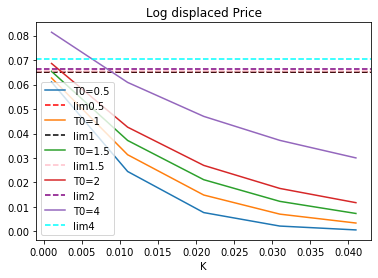

In [89]:
#Plot du prix log displaced en fonction de T0 et K et limite BS

strikes = np.arange(0.001,0.05,0.01)
T0s = [0.5,1,1.5,2,4]
colors=['r','black','pink','purple','cyan']
i=0
for t in T0s:
    maturities = np.arange(t,t+5.5,0.5)
    bonds = ZC[int(2*t):int(2*t)+11]
    limit = A(0,0,0,maturities,bonds,1,chi)*S(0,0,0,maturities,bonds,1,chi)
    log_disp_prices_K = [log_displaced(sigma,b,k,maturities,bonds) for k in strikes]
    plt.plot(strikes,log_disp_prices_K,label="T0="+str(t))
    plt.axhline(y=limit, color=colors[i] ,linestyle='--',label="lim" + str(t))
    i +=1
    
plt.xlabel("K")
plt.title("Log displaced Price")
plt.legend()

In [133]:
S(0,0,0,maturities,bonds,1,chi)

0.0506302410488577

**One observes that the price in this model overcomes the Black & Scholes limit as K tends to 0 and $T_0$ tends to $T_N$.**

Mathematically speaking, $$\lim_{T_0 \rightarrow + \infty} \lim_{K \rightarrow 0^+} d^{+ /_-} = + /_- \infty$$

Hence $$\lim_{T_0 \rightarrow + \infty} \lim_{K \rightarrow 0^+} V_{Swaption LD} = \frac{A(0) S(0)}{b} \ge A(0) S(0) = \lim_{\sigma \rightarrow + \infty} V_{BS}$$ 

It is then possible that the Price from the log-displaced model overcomes the superior bound of the Black Scholes Price for low values of strike and values of maturity near to $T_N$.

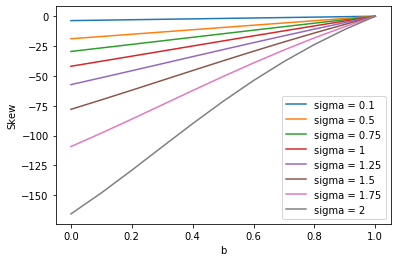

In [91]:
def skew_ld(T0s,b,sigma):
    skew = np.zeros(T0s.size)
    for i in range(T0s.size):
        T0 = T0s[i]
        tenor = np.arange(T0,T0+5.5,0.5)  #tenor of the swaption between T0 and 5Y
        bonds = ZC[int(T0*2):int(2*T0)+11]
        ATM = S(0,0,0,tenor,bonds,1,chi)   # ATM rate = S0
        Price_95 = log_displaced(sigma,b,0.95*ATM,tenor,bonds) #Swaption Price at 95% of the ATM strike
        Price_105 = log_displaced(sigma,b,1.05*ATM,tenor,bonds) #Swaption Price at 105% of the ATM strike
        #skew[i] = (bissectrice(10,Price_105, bonds, 1.05*ATM, tenor) - bissectrice(10,Price_95, bonds, 0.95*ATM, tenor))/(0.1*ATM)
        skew[i] = (biss_python(Price_105, bonds, 1.05*ATM, tenor) - biss_python(Price_95, bonds, 0.95*ATM, tenor))/(0.1*ATM)
    return skew

# T0 fixed, skew ATM with respect to b
b_vals = np.arange(0,1.1,0.1)
for s in [0.1,0.5,0.75,1,1.25,1.5,1.75,2]:
    skew = [skew_ld(np.array([1]),b,s) for b in b_vals]
    plt.plot(b_vals,skew,label="sigma = "+str(s))
plt.legend()
plt.xlabel("b")
plt.ylabel("Skew")
plt.show()

## 9.Pricing by Gaussian swap rate approximation ( p.422 10.1.3.2)

A simple way to approximate the swaption price is to consider the swap rate purely gaussian such that $\mathrm{d}S_t = \sigma(t) \ \mathrm{d}W_t$. In this case, one has $$\begin{array}{ll} \mathbb{E}\Big[ (S_T - K)^+ \ | \mathcal{F}_t\Big] &= \mathbb{E}\Big[ (S_T - K)^+ \ | S_t=S\Big] \\
&= \mathbb{E}\Big[ \Big(S - K + \int_t^T \sigma(s) \ \mathrm{d}W_s\Big) \mathbb{1}_{S_T>K} \ | S_t=S\Big] \\
&= (S-K) \Phi\Big( \frac{S-K}{\sqrt{v}}\Big) +  \sqrt{v} \int_{\frac{K-S}{\sqrt{v}}}^{\infty} \frac{x}{\sqrt{2\pi}} e^{-\frac{x^2}{2}} \, \mathrm{d}x \\
&= (S-K) \Phi( d ) + \sqrt{v} \phi(d)
\end{array}$$ Where $$v = \int_t^T \sigma(s)^2 \ \mathrm{d}s$$

Under the annuity measure, the Ito's lemma implies $\mathrm{d}S_t = \frac{\partial S}{\partial x}(t,x(t),y(t)) \ \sigma_r(t,x(t)) \ \mathrm{d}W_t^A$ and one let $q = \frac{\partial S}{\partial x}$. But $x$ is stochastic here, that's why one will approximate $x$ by a deterministic function $\bar{x}$

Hence $$\boxed{V_0 \approx A(0) \Big[\big(S(0) -K \big) \Phi(d) \ + \ \sqrt{v} \phi(d) \Big] \\
d= \frac{S(0)-K}{\sqrt{v}} \quad v = \int_{0}^{T_0} q(t,\bar{x}(t),\bar{y}(t))^2 \ \sigma_r(t,\bar{x}(t))^2 \ \mathrm{d}t}$$

Where $$q(t,x) = -\frac{P(t,T_0,x) G(t,T_0) - P(t,T_N,x)G(t,T_N)}{A(t,x)} \ + \ \frac{S(t,x)}{A(t,x)}\sum_{i=0}^{N-1} \tau_i P(t,T_{i+1},x) G(t,T_{i+1})$$

If $\bar{x}$ is deterministic, the new approached dynamic of $\bar{y}$ is $\mathrm{d}\bar{y}(t) = \Big(\lambda^2 (a + b \bar{x}(t))^2 - 2 \chi(t) y(t) \Big) \ \mathrm{d}t$ and it is an ODE which can be easily solved by:
$$\bar{y}(t) = \int_0^t e^{-2\int_s^t \chi(u) \ \mathrm{d}u} \lambda^2 (a+b\bar{x}(s))^2 \ \mathrm{d}s$$

The problem here is to find an approximated value of the integral $v$ which depends of the whole path of $t \rightarrow x(t)$ on $[0,T_0]$.

$$\int_{0}^{T_0} q(t,\bar{x}(t),\bar{y}(t))^2 \ \sigma_r(t,\bar{x}(t))^2 \ \mathrm{d}t
= \lim_{N \rightarrow \infty} \sum_{i=0}^{N-1} q(t,x_i,y_i)^2 \ \sigma_r(t,x_i)^2 \ (t_{i+1}-t_i)$$

Practically speaking, the integral $v$ will be numerically computed by scipy.integrate algorithm

### a. Basic approximation $\bar{x} = 0$

In this case, one has $y(t,\bar{x}(t)) = y_0(t) =  \frac{\lambda^2 a^2}{2 \chi} (1 - e^{-2\chi t})$

In [16]:
# t -> y(t) if chi, lambda, a constant
def y0(t,lmbda,a,chi):
    return (lmbda*a)**2 * (1-np.exp(-2*chi*t))/(2*chi)

#Swaption Pricing in the gaussian swap rate approximation

def swaption_gauss(K,maturities,bonds,lmbda,a,b,chi,x):
    nb_maturities = maturities.size
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = A(0,0,0,maturities,bonds,1,chi)

    v = lmbda**2 * (integrate.quad(lambda t: q(t,x(t),y0(t,lmbda,a,chi),maturities,bonds,np.exp(-r*t),chi)**2 *(a + b*x(t))**2 ,0,maturities[0])[0])  
    d = (S0-K)/np.sqrt(v)
    return A0*((S0-K)*stats.norm.cdf(d) + np.sqrt(v)*gaussian_density(d))

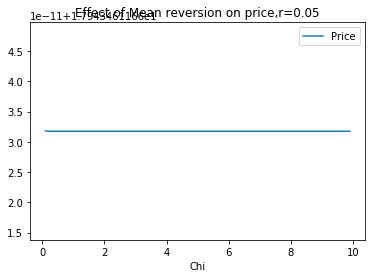

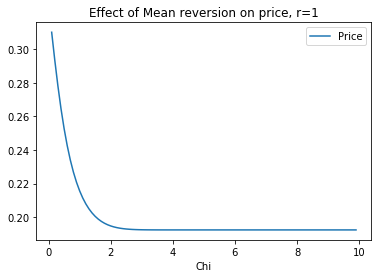

In [17]:
T0 = 0.5
maturities = np.arange(T0,T0+5.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
mean_reversion_val = np.arange(0.1,10,0.1)
swaptions = [swaption_gauss(K,maturities,bonds,lmbda,a,b,mr,lambda t: 0) for mr in mean_reversion_val]
plot2D(mean_reversion_val,swaptions,"Chi","Price","Effect of Mean reversion on price,r=0.05")

r = 1
bonds = [np.exp(-r*m) for m in maturities]
swaptions = [swaption_gauss(K,maturities,bonds,lmbda,a,b,mr,lambda t: 0) for mr in mean_reversion_val]

plot2D(mean_reversion_val,swaptions,"Chi","Price","Effect of Mean reversion on price, r=1")

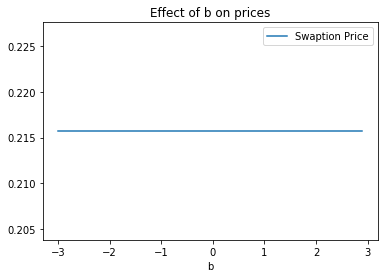

In [18]:
b_val = np.arange(-3,3,0.1)

swaptions = [swaption_gauss(K,maturities,bonds,lmbda,a,bi,chi,lambda t: 0) for bi in b_val]

plot2D(b_val,swaptions,'b','Swaption Price','Effect of b on prices')

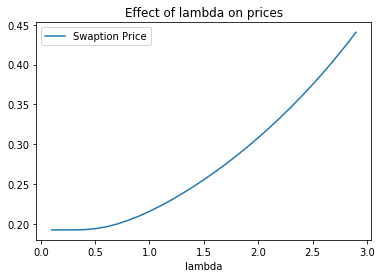

In [19]:
lmbdas = np.arange(0.1,3,0.1)

swaptions1 = [swaption_gauss(K,maturities,bonds,l,a,b,chi,lambda t: 0) for l in lmbdas]

plot2D(lmbdas,swaptions1,'lambda','Swaption Price','Effect of lambda on prices')

### First order approximation of $\mathbb{E}_{\mathbb{Q}^A} \big[x(t) \big]$

If $(t,s) \rightarrow X(t,s)$ is the solution to $\color{red} {(1)}$: $S(t,X(t,s),\bar{y}(t)) = s$ and if one notes $x_0(t) = X(t,S(0))$

Recalling that $$S(t,x,y) = \frac{P(t,T_0,x,y)-P(t,T_N,x,y)}{\sum_{n=0}^{N-1} \tau_n P(t,T_{n+1},x,y)}$$ the swap rate is smooth, increasing and 2 times differentiable in x.  

Assuming that $S$ is a square integrable martingale under annuity measure, then by martingale representation theorem and Itô's formula, one has $\mathrm{d}S(t) = \frac{\partial S}{\partial x}(s,x(t),y(t)) \ \sigma_r(s,x(t)) \ \mathrm{d}W_t^A$ 

So for $(t,s)$ such that $\frac{\partial S}{\partial x}(t,X(t,s),\bar{y}(t)) \ne 0$, $X$ is also 2-times differentiable.

Then by Taylor's formula $$x(t) = X(t,S(t)) = x_0(t) + \frac{\partial X}{\partial s}(t,S(0)) \ \times (S(t) - S(0)) + \mathcal{O} (S(t)-S(0))^2$$ and by taking the expectation under annuity measure, as the swap rate is a $\mathbb{Q}^A$ martingale one has $$\boxed{\mathbb{E}_{\mathbb{Q}^A} \big[x(t)\big] - x_0(t) = \mathcal{O} (\mathbb{E}_{\mathbb{Q}^A}(S(t)-S(0))^2 )}$$

### Second order approximation (Piterbarg p.545)

The second order approximation is given by: $$x(t)- x_0(t) = \frac{\partial X}{\partial s}(t,S(0)) \ \times (S(t) - S(0)) + \frac{1}{2}\frac{\partial^2 X}{\partial s^2}(t,S(0)) \times (S(t)-S(0))^2 + \mathcal{O} ((S(t)-S(0))^3 )$$ 

By taking expectation again, it yields $$\boxed{\mathbb{E}_{\mathbb{Q}^A} \big[x(t)\big] = x_0(t) + \frac{1}{2}\frac{\partial^2 X}{\partial s^2}(t,S(0)) \times Var^A [S(t)] + \mathcal{O} (\mathbb{E}_{\mathbb{Q}^A}(S(t)-S(0))^3 )}$$ **(1/2 vanishes?)**

One needs to express the second derivative of X by differentiating two times $\color{red}{(1)}$ in s $$\frac{\partial^2 X}{\partial s^2}(t,s) = -\frac{\frac{\partial^2 S}{\partial x^2}(t,X(t,s),\bar{y}(t))}{\Big( \frac{\partial S}{\partial x}(t,X(t,s),\bar{y}(t)) \Big)^3}$$

**Remark: The difficulty lies in the expression of the variance because the volatility of the swap rate is stochastic. One has therefore $$Var^A[S(t)] = \mathbb{E}_{\mathbb{Q}^A} \Big[ \int_0^t \frac{\partial S}{\partial x}(s,x(s),\bar{y}(s))^2 \sigma_r(s,x(s))^2 \ \mathrm{d}s \Big]$$ which would be approximate by a Monte Carlo algorithm for instance.
But one possibility is to assume the swap rate gaussian with a deterministic volatility $\frac{\partial S}{\partial x}(s,0,0) \sigma_r(s,0)$ such that $Var^A[S(t)] \approx \int_0^t \frac{\partial S}{\partial x}(s,0,0)^2 \sigma_r(s,0)^2 \ \mathrm{d}s$** 

### b.Pricing with first order approximation for x

In [20]:
#First order approximation x0(t)

def x0(t,maturities,bonds,lmbda,a,chi):
    #A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    g0 = G(t,maturities[0],chi)
    gN = G(t,maturities[-1],chi)
    y = y0(t,lmbda,a,chi)
    Swap_rate = lambda x: S(t,x,y,maturities,bonds,np.exp(-r*t),chi) - S0
    dS = lambda x: q(t,x,y,maturities,bonds,np.exp(-r*t),chi)
    return opt.newton(Swap_rate,0,dS)  #Newton method
    #return opt.newton(Swap_rate,0) # secant method 

In [21]:
#test
t = 0.5
y = y0(t,lmbda,a,chi)
maturities = np.arange(t,t+5.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
S0 = S(0,0,0,maturities,bonds,1,chi)
x = x0(t,maturities,bonds, lmbda,a,chi)
print("x0= ",x,"S0= ",S0,"S(t,x0,y_bar)= ",S(t,x,y,maturities,bonds,np.exp(-r*t),chi))

x0=  0.7202816907079052 S0=  1.2974425414002564 S(t,x0,y_bar)=  1.2974425349574532


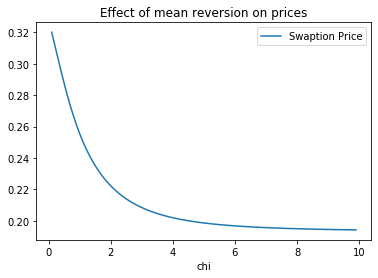

In [27]:
mean_reversion_val = np.arange(0.1,10,0.1)

swaptions = [swaption_gauss(K,maturities,bonds,lmbda,a,b,mr,lambda t: x0(t,maturities,bonds,lmbda,a,mr)) for mr in mean_reversion_val]

plot2D(mean_reversion_val,swaptions,'chi','Swaption Price','Effect of mean reversion on prices')

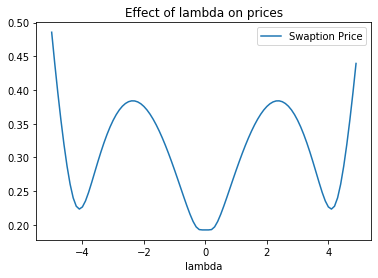

In [74]:
lmbdas = np.arange(-5,5,0.1)

swaptions1 = [swaption_gauss(K,maturities,bonds,l,a,b,chi,lambda t: x0(t,maturities,bonds,l,a,chi)) for l in lmbdas]

plot2D(lmbdas,swaptions1,'lambda','Swaption Price','Effect of lambda on prices')

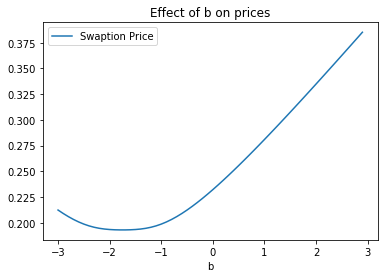

In [75]:
b_vals = np.arange(-3,3,0.1)

swaptions = [swaption_gauss(K,maturities,bonds,lmbda,a,bi,chi,lambda t: x0(t,maturities,bonds,lmbda,a,chi)) for bi in b_vals]

plot2D(b_vals,swaptions,'b','Swaption Price','Effect of b on prices')

**Remark:** The positive slope of the swaption price with respect to b is explained by the fact that $\frac{\partial V_0}{\partial \sqrt{v}} \ge 0$ and that the integrated function in $v$ becomes flat when b decreases. 

Detail: $$\frac{\partial V_0}{\partial \sqrt{v}} = -A(0) \frac{(S(0)-K)^2}{v} \phi(d) + A(0) \phi(d) - A(0) \phi '(d) \frac{(S(0)-K)}{\sqrt{v}} = A(0) \phi(d) \big[ 1 - d^2 + d^2\big] = A(0) \phi(d) \ge 0$$

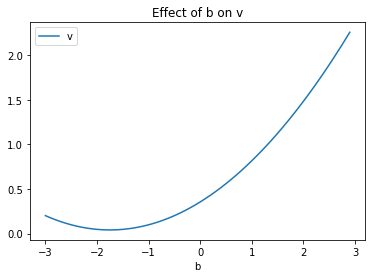

In [146]:
v = np.zeros(b_vals.size)
for i in range(b_vals.size):
    v[i] = integrate.quad(lambda t: q(t,x0(t,maturities,bonds,lmbda,a,chi),y0(t,lmbda,a,chi),maturities,bonds,np.exp(-r*t),chi)**2 *(a + b_vals[i]*x0(t,maturities,bonds,lmbda,a,chi))**2 ,0,maturities[0])[0]
plot2D(b_vals,v,'b',"v","Effect of b on v")

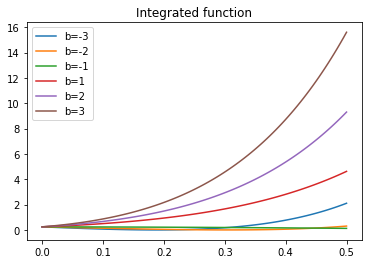

In [147]:
t_val = np.linspace(0,T0,100)
x = [q(t,x0(t,maturities,bonds,lmbda,a,chi),y0(t,lmbda,a,chi),maturities,bonds,np.exp(-r*t),chi)**2 * (a+1*x0(t,maturities,bonds,lmbda,a,chi))**2 for t in t_val]
y = [q(t,x0(t,maturities,bonds,lmbda,a,chi),y0(t,lmbda,a,chi),maturities,bonds,np.exp(-r*t),chi)**2 * (a+2*x0(t,maturities,bonds,lmbda,a,chi))**2 for t in t_val]
z = [q(t,x0(t,maturities,bonds,lmbda,a,chi),y0(t,lmbda,a,chi),maturities,bonds,np.exp(-r*t),chi)**2 * (a-3*x0(t,maturities,bonds,lmbda,a,chi))**2 for t in t_val]
u = [q(t,x0(t,maturities,bonds,lmbda,a,chi),y0(t,lmbda,a,chi),maturities,bonds,np.exp(-r*t),chi)**2 * (a-2*x0(t,maturities,bonds,lmbda,a,chi))**2 for t in t_val]
v = [q(t,x0(t,maturities,bonds,lmbda,a,chi),y0(t,lmbda,a,chi),maturities,bonds,np.exp(-r*t),chi)**2 * (a-1*x0(t,maturities,bonds,lmbda,a,chi))**2 for t in t_val]
w = [q(t,x0(t,maturities,bonds,lmbda,a,chi),y0(t,lmbda,a,chi),maturities,bonds,np.exp(-r*t),chi)**2 * (a+3*x0(t,maturities,bonds,lmbda,a,chi))**2 for t in t_val]
plt.plot(t_val,z,label="b=-3")
plt.plot(t_val,u,label="b=-2")
plt.plot(t_val,v,label="b=-1")
plt.plot(t_val,x,label="b=1")
plt.plot(t_val,y,label="b=2")
plt.plot(t_val,w,label="b=3")
plt.title("Integrated function")
plt.legend()

### c.Pricing with second order approximation for x

One precises the calculus of the second derivative term in $\bar{x}(t)$.
By differentiating 2 times the expression of swap rate in x, it yields $$\begin{array}{ll}
\frac{\partial S}{\partial x}(t,x,y) = \frac{-1}{A(t,x,y)} \Big(G(t,T_0) P(t,T_0,x,y) - G(t,T_N) P(t,T_N,x,y) \Big) + \frac{S(t,x,y)}{A(t,x,y)} \sum_{n=0}^{N-1} \tau_n G(t,T_{n+1}) P(t,T_{n+1},x,y) \quad \\ \text{and} \
\frac{\partial^2 S}{\partial x^2}(t,x,y) = \frac{1}{A(t,x,y)} \Big[ G(t,T_0)^2 P(t,T_0,x,y) - G(t,T_N)^2 P(t,T_N,x,y) - S(t,x,y) \frac{\partial^2 A}{\partial x^2} \Big] - \frac{\partial A}{\partial x} \Big[ \frac{\frac{\partial S}{\partial x}}{A(t,x,y)} - \frac{G(t,T_0) P(t,T_0,x,y) - G(t,T_N) P(t,T_N,x,y)}{A(t,x,y)^2} \Big] + \Big( \frac{\partial A}{\partial x} \Big)^2 \frac{S(t,x,y)}{A(t,x,y)^2} \\
= \frac{1}{A(t,x,y)} \Big[ G(t,T_0)^2 P(t,T_0,x,y) - G(t,T_N)^2 P(t,T_N,x,y) - S(t,x,y) A''(t,x,y) \Big] +\frac{2 A'(t,x,y)}{A(t,x,y)^2} \Big( A'(t,x,y) S(t,x,y) + \big(G(t,T_0) P(t,T_0,x,y) - G(t,T_N) P(t,T_N,x,y)\big) \Big)
\end{array}$$

Where $A' \& A''$ are derivatives with respect to $x$

In [22]:
 #second derivative d2S/dx2
def dS2(t,x,y,maturities,bonds,ZC_t,chi):
    g0 = G(t,maturities[0],chi)
    gN = G(t,maturities[-1],chi)
    PT0 = (np.exp(-r*(maturities[0]-t))*np.exp(-1*g0*x-0.5*y*g0**2))
    PTN = (np.exp(-r*(maturities[-1]-t))*np.exp(-1*gN*x-0.5*y*gN**2))
    At = A(t,x,y,maturities,bonds,ZC_t,chi)
    Aprime = A(t,x,y,maturities,bonds,ZC_t,chi,1)
    Apprime = A(t,x,y,maturities,bonds,ZC_t,chi,2)
    S_rate = S(t,x,y,maturities,bonds,ZC_t,chi)
    return (g0**2 * PT0 - gN**2 * PTN - S_rate * Apprime)/At + 2*Aprime * (Aprime*S_rate + g0*PT0 - gN*PTN)/(At**2)

#second order approximation
def x_bar(t,maturities,bonds,ZC_t,lmbda,a,chi):
    y = y0(t,lmbda,a,chi)
    x = x0(t,maturities,bonds,lmbda,a,chi)
    #second derivative d2S/dx2
    d2S = dS2(t,x,y,maturities,bonds,ZC_t,chi)
    #second derivative d2X/ds2
    dX2 = -1*d2S/(q(t,x,y,maturities,bonds,ZC_t,chi)**3)
    Var = lmbda**2 * a**2 *integrate.quad(lambda s:  q(s,0,0,maturities,bonds,np.exp(-r*s),chi)**2,0,t)[0]
    return x + 0.5 * dX2 * Var

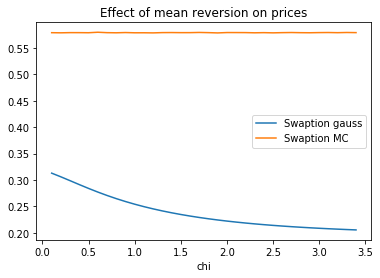

In [151]:
mean_reversion_val = np.arange(0.1,3.5,0.1)

swaptions = [swaption_gauss(K,maturities,bonds,lmbda,a,b,mr,lambda t: x_bar(t,maturities,bonds,np.exp(-r*t),lmbda,a,mr)) for mr in mean_reversion_val]
swaptions2 = []
for mr in mean_reversion_val:
    sim = simul(lmbda,a,b,mr,T0,N,M,"Euler")
    swaptions2.append(swaption_MC(M,sim,K,mr,bonds,maturities))
plot2D(mean_reversion_val,swaptions,'chi','Swaption gauss','Effect of mean reversion on prices',swaptions2,"Swaption MC")

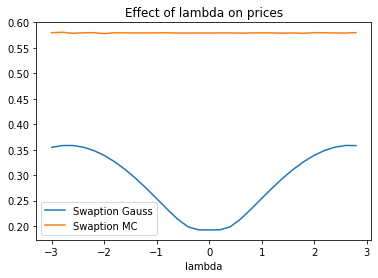

In [27]:
lmbdas = np.arange(-3,3,0.2)

swaptions1 = [swaption_gauss(K,maturities,bonds,l,a,b,chi,lambda t: x_bar(t,maturities,bonds,np.exp(-r*t),l,a,chi)) for l in lmbdas]
swaptions2 = []
for l in lmbdas:
    sim = simul(l,a,b,chi,T0,N,M,"Euler")
    swaptions2.append(swaption_MC(M,sim,K,chi,bonds,maturities))
plot2D(lmbdas,swaptions1,'lambda','Swaption Gauss','Effect of lambda on prices',swaptions2,"Swaption MC")

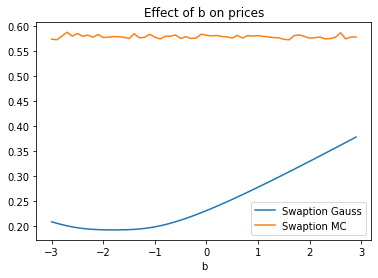

In [77]:
b_vals = np.arange(-3,3,0.1)

swaptions1 = [swaption_gauss(K,maturities,bonds,lmbda,a,bi,chi,lambda t: x_bar(t,maturities,bonds,np.exp(-r*t),lmbda,a,chi)) for bi in b_vals]
swaptions2 = []
for bi in b_vals:
    sim = simul(lmbda,a,bi,chi,T0,N,M,"Euler")
    swaptions2.append(swaption_MC(M,sim,K,chi,bonds,maturities))
plot2D(b_vals,swaptions1,'b','Swaption Gauss','Effect of b on prices',swaptions2,"Swaption MC")

## 10.Pricing by displaced log-normal approximation (Piterbarg p.548)

One can approximate the dynamic of the swap rate by the dynamic of a displaced log-normal process with time-dependent parameters, which writes $$\mathrm{d}S(t) \approx \lambda_S(t) \big( b_S(t) S(t) + (1-b_S(t))S(0) \big) \ \mathrm{d}W^A(t)$$

Where $$\left\{
    \begin{array}{ll}
\lambda_{S}(t)=\lambda\frac{1}{S(0)} \frac{\partial S}{\partial x}(t, \bar{x}(t), \bar{y}(t))\left(a +b \bar{x}(t)\right) \\
b_{S}(t)=\frac{S(0)}{\left(a +b \bar{x}(t)\right)} \frac{b}{\frac{\partial S}{\partial x}(t, \bar{x}(t), \bar{y}(t))}+\frac{S(0) \frac{\partial^{2} S}{\partial x^{2}}(t, \bar{x}(t), \bar{y}(t))}{\left(\frac{\partial S}{\partial x}(t, \bar{x}(t), \bar{y}(t))\right)^{2}}
\end{array}
\right.
$$

By taking chosen average values for each parameter, which are: $$
\begin{aligned}
\bar{\lambda}_{S} &=\left(\frac{1}{T_{0}} \int_{0}^{T_{0}} \lambda_{S}(t)^{2} d t\right)^{1 / 2} \\
\bar{b}_{S} &=\int_{0}^{T_{0}} b_{S}(t) w_{S}(t) d t \\
w_{S}(t) &=\frac{\lambda_{S}(t)^{2} \int_{0}^{t} \lambda_{S}(s)^{2} d s}{\int_{0}^{T_{0}}\left(\lambda_{S}(u)^{2} \int_{0}^{u} \lambda_{S}(s)^{2} d s\right) d u}
\end{aligned}
$$

Our price can be approximated by the swaption pricing formula under a log-displaced swap rate (such as in section 8.g) with the parameters above.

This yields to $$\boxed{V_0 = A(0) \Big( \big(S(0)+\frac{1-\bar{b}_{S}}{\bar{b}_{S}}S(0) \big) \Phi(d^+) - \big(K+ \frac{1-\bar{b}_{S}}{\bar{b}_{S}}S(0)\big) \Phi(d^-) \Big) \\
d^{+/-} = \frac{\ln{\big( \frac{S(0) + S(0)\frac{1-\bar{b}_{S}}{\bar{b}_{S}}}{K+S(0)\frac{1-\bar{b}_{S}}{\bar{b}_{S}}}\big)} +_{/-} \frac{\bar{\lambda}_S^2 \bar{b}_S^2}{2}T_0}{\bar{\lambda}_S \bar{b}_S \sqrt{T_0}}}$$

In [25]:
#function t -> lambda_S  in the pricing formula
def lS(t,x,y,lmbda,a,b,chi,maturities,bonds,ZC_t):
    S0 = S(0,0,0,maturities,bonds,1,chi)
    dS = q(t,x,y,maturities,bonds,ZC_t,chi)
    return (lmbda/S0) * dS * (a + b * x)

#function t -> b_S  in the pricing formula
def bS(t,x,y,lmbda,a,b,chi,maturities,bonds,ZC_t):
    S0 = S(0,0,0,maturities,bonds,1,chi)
    dS = q(t,x,y,maturities,bonds,ZC_t,chi)
    d2S = dS2(t,x,y,maturities,bonds,ZC_t,chi)
    return (S0 * b) / ((a + b * x) * dS) + S0 * d2S/(dS**2)

def Swaption_LD(K,lmbda,a,b,chi,maturities,bonds,exec_time= False):
    t1 = time()
    T0 = maturities[0]
    f = lambda s: integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbda,a,chi),y0(u,lmbda,a,chi),lmbda,a,b,chi,maturities,bonds,np.exp(-r*u))**2 ,0,s)[0]
    lambda_bar = np.sqrt(f(T0)/T0)
    denom_w = integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbda,a,chi),y0(u,lmbda,a,chi),lmbda,a,b,chi,maturities,bonds,np.exp(-r*u))**2 * f(u),0,T0)[0]
    w = lambda s: (lS(s,x_bar(s,maturities,bonds,np.exp(-r*s),lmbda,a,chi),y0(s,lmbda,a,chi),lmbda,a,b,chi,maturities,bonds,np.exp(-r*s))**2 * f(s)) / denom_w
    b_bar = integrate.quad(lambda u: bS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbda,a,chi),y0(u,lmbda,a,chi),lmbda,a,b,chi,maturities,bonds,np.exp(-r*u)) * w(u),0,T0)[0]
    
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    
    C = S0 * (1-b_bar)/b_bar
    arg_ln = (S0 + C )/(K + C)
    d = (np.log(arg_ln) + 0.5 * b_bar**2 * lambda_bar**2 * T0) / (b_bar * lambda_bar * np.sqrt(T0))
    t2 = time()
    if(exec_time):
        print("Exec_time:",t2-t1)
    return A0 * ( (S0 + C) * stats.norm.cdf(d) - (K + C) * stats.norm.cdf(d - b_bar*lambda_bar*np.sqrt(T0)))

In our code, one notes for simplification $$f : t \rightarrow \int_{0}^{t} \lambda_{S}(s)^{2} d s$$

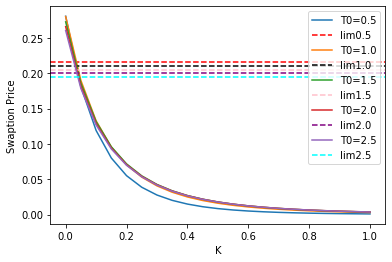

In [30]:
colors=['r','black','pink','purple','cyan']
T0s = np.arange(0.5,3,0.5)
strikes = np.arange(0,1.05,0.05)
i=0
for t in T0s:
    maturities = np.arange(t,t + 5.5,0.5)
    bonds = [np.exp(-r*m) for m in maturities]
    swaption = [Swaption_LD(k,lmbda,a,b,chi,maturities,bonds) for k in strikes]
    plt.plot(strikes,swaption,label="T0=" + str(t))
    limit = S(0,0,0,maturities,bonds,1,chi)*A(0,0,0,maturities,bonds,1,chi)
    plt.axhline(y=limit, color=colors[i] ,linestyle='--',label="lim" + str(t))
    i +=1
plt.legend()
plt.xlabel("K")
plt.ylabel("Swaption Price")
plt.show()

### Difference with Monte Carlo Pricing

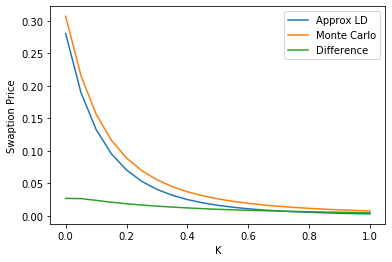

In [31]:
strikes = np.arange(0,1.05,0.05)
maturities = np.arange(1,6.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
sim = simul(lmbda,a,b,chi,1,N,M,"Euler")
MC = [swaption_MC(M,sim,k,chi,bonds,maturities) for k in strikes]
swaption = [Swaption_LD(k,lmbda,a,b,chi,maturities,bonds) for k in strikes]
plt.plot(strikes,swaption,label="Approx LD")
plt.plot(strikes,MC,label="Monte Carlo")
diff = np.array(MC) - np.array(swaption)
plt.plot(strikes,diff,label="Difference")
plt.legend()
plt.xlabel("K")
plt.ylabel("Swaption Price")
plt.show()

One observes a difference between swaption prices generated by Monte Carlo and thus generated by the displaced log-normal approximation formula which seems to be higher at the money.

In [32]:
### Execution time
Swaption_LD(K,lmbda,a,b,chi,maturities,bonds,True)
t_start = time()
sim = simul(lmbda,a,b,chi,1,N,M,"Euler")
swaption_MC(M,sim,K,chi,bonds,maturities)
t_finish = time()
print("Exec. duration MC:",t_finish-t_start)

Exec_time: 3.927006244659424
Exec. duration MC: 83.80881810188293


### Effect of $b$ on Implied volatility

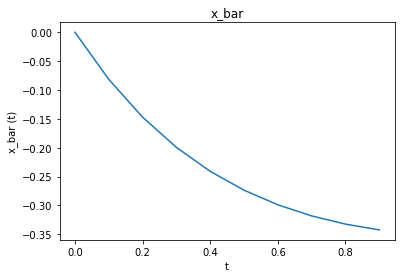

In [33]:
tim = np.arange(0,1,0.1)
x_curve = [x_bar(t,maturities,bonds,np.exp(-r*t),lmbda,a,chi) for t in tim]
plt.plot(tim,x_curve)
plt.xlabel("t")
plt.ylabel("x_bar (t)")
plt.title("x_bar")
plt.show()

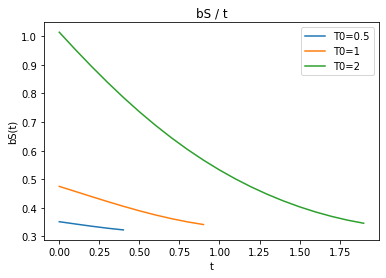

In [34]:
for T0 in [0.5,1,2]:
    maturities = np.arange(T0,T0 + 5.5,0.5)
    bonds = [np.exp(-r*m) for m in maturities]
    tim = np.arange(0,T0,0.1)
    b_curve = [bS(t,x_bar(t,maturities,bonds,np.exp(-r*t),lmbda,a,chi),y0(t,lmbda,a,chi),lmbda,a,b,chi,maturities,bonds,np.exp(-r*t)) for t in tim]
    plt.plot(tim,b_curve,label="T0="+str(T0))
plt.xlabel("t")
plt.ylabel("bS(t)")
plt.legend()
plt.title("bS / t")
plt.show()

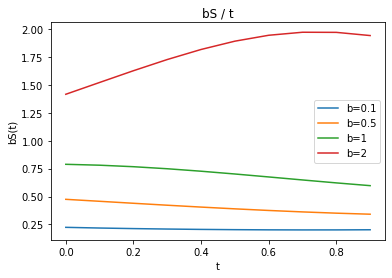

In [35]:
T0 = 1
maturities = np.arange(T0,T0 + 5.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
tim = np.arange(0,T0,0.1)
for bi in [0.1,0.5,1,2]:
    b_curve = [bS(t,x_bar(t,maturities,bonds,np.exp(-r*t),lmbda,a,chi),y0(t,lmbda,a,chi),lmbda,a,bi,chi,maturities,bonds,np.exp(-r*t)) for t in tim]
    plt.plot(tim,b_curve,label="b="+str(bi))
plt.xlabel("t")
plt.ylabel("bS(t)")
plt.legend()
plt.title("bS / t")
plt.show()

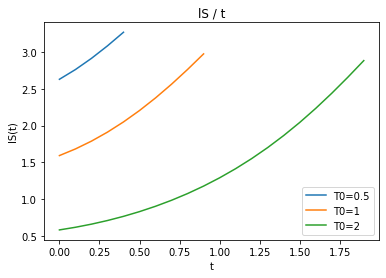

In [36]:
for T0 in [0.5,1,2]:
    maturities = np.arange(T0,T0 + 5.5,0.5)
    bonds = [np.exp(-r*m) for m in maturities]
    tim = np.arange(0,T0,0.1)
    l_curve = [lS(t,x_bar(t,maturities,bonds,np.exp(-r*t),lmbda,a,chi),y0(t,lmbda,a,chi),lmbda,a,b,chi,maturities,bonds,np.exp(-r*t)) for t in tim]
    plt.plot(tim,l_curve,label="T0="+str(T0))
plt.xlabel("t")
plt.ylabel("lS(t)")
plt.legend()
plt.title("lS / t")
plt.show()

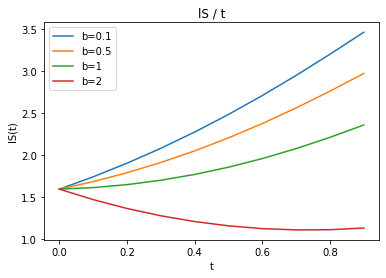

In [37]:
T0 = 1
maturities = np.arange(T0,T0 + 5.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
tim = np.arange(0,T0,0.1)
for bi in [0.1,0.5,1,2]:
    l_curve = [lS(t,x_bar(t,maturities,bonds,np.exp(-r*t),lmbda,a,chi),y0(t,lmbda,a,chi),lmbda,a,bi,chi,maturities,bonds,np.exp(-r*t)) for t in tim]
    plt.plot(tim,l_curve,label="b="+str(bi))
plt.xlabel("t")
plt.ylabel("lS(t)")
plt.legend()
plt.title("lS / t")
plt.show()

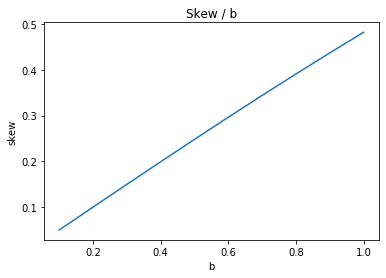

In [38]:
def skew(K,T0,b,l):
    maturities = np.arange(T0,T0+5.5,0.5)
    bonds = [np.exp(-r*m) for m in maturities]
    S0 = S(0,0,0,maturities,bonds,1,chi)
    sigma_imp = biss_python(log_displaced(l,b,K,maturities,bonds),bonds,K,maturities,"normal")
    d = (S0 - K)/(sigma_imp * np.sqrt(T0))
    d_moins = (np.log(S0/(b*K+(1-b)*S0)) - 0.5 * b**2 * l**2 * T0) / (b * l * np.sqrt(T0))
    return (gaussian_density(d_moins)/(b*np.sqrt(T0)) + stats.norm.cdf(d) - stats.norm.cdf(d_moins) - S0*gaussian_density(d_moins + l*b*np.sqrt(T0))/(b*np.sqrt(T0)*(b*K+(1-b)*S0)))/(np.sqrt(T0)*gaussian_density(d))

b_vals = np.arange(0.1,1.1,0.1)
skew_curve = [skew(0.05,1,bi,1) for bi in b_vals] #Struck at 0.05
plt.plot(b_vals,skew_curve)
plt.xlabel("b")
plt.ylabel("skew")
plt.title("Skew / b")
plt.show()

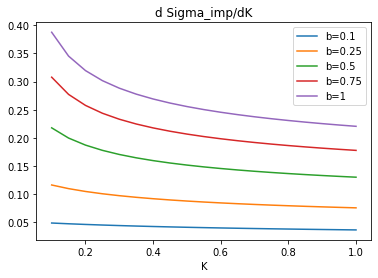

In [39]:
T0=1
strikes = np.arange(0.1,1.05,0.05)
for bi in [0.1,0.25,0.5,0.75,1]:
    curve = [skew(k,T0,bi,1) for k in strikes]
    plt.plot(strikes,curve,label="b="+str(bi))
plt.legend()
plt.title("d Sigma_imp/dK")
plt.xlabel('K')
plt.show()

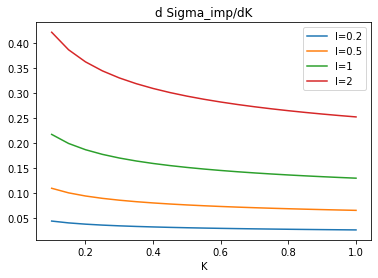

In [56]:
T0=1
strikes = np.arange(0.1,1.05,0.05)
for l in [0.2,0.5,1,2]:
    curve = [skew(k,T0,0.5,l) for k in strikes]
    plt.plot(strikes,curve,label="l="+str(l))
plt.legend()
plt.title("d Sigma_imp/dK")
plt.xlabel('K')
plt.show()

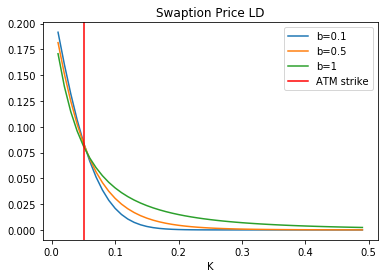

In [40]:
# Swaption price (LD) 
T0=1
maturities = np.arange(T0,T0 + 5.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
strikes = np.arange(0.01,0.5,0.01)
for bi in [0.1,0.5,1]:
    curve = [log_displaced(1,bi,k,maturities,bonds) for k in strikes]
    plt.plot(strikes,curve,label="b="+str(bi))
plt.title("Swaption Price LD")
plt.xlabel('K')
plt.axvline(S(0,0,0,maturities,bonds,1,chi), 0, 1, label='ATM strike',color='r')
plt.legend()
plt.show()

11.11111111111111 %
22.22222222222222 %
33.333333333333336 %
44.44444444444444 %
55.55555555555556 %
66.66666666666667 %
77.77777777777777 %
88.88888888888889 %
100.0 %


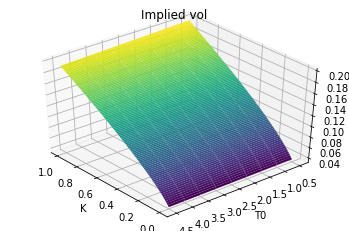

In [42]:
# IV vol. surface in normal model with displaced log-normal prices

strikes = np.arange(0,1,0.01)
T0s = np.arange(0.5,5,0.5)
X,Y = np.meshgrid(strikes, T0s)
surface = np.zeros((T0s.size,strikes.size))
i,j= 0,0
compteur = 0
for t in T0s:
    maturities = np.arange(t,t + 5.5,0.5)
    bonds = [np.exp(-r*m) for m in maturities]
    for k in strikes:
        Price = log_displaced(1,0.5,k,maturities,bonds)
        surface[i][j] = biss_python(Price,bonds,k,maturities,"normal")
        j = (j+1)%strikes.size
        compteur +=1
    i+=1
    print(compteur*100/(T0s.size*strikes.size),'%')
plot3D(X,Y,surface,140)

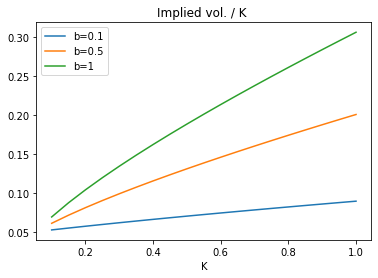

In [44]:
#Implied vol. with b
T0=1
maturities = np.arange(T0,T0 + 5.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
strikes = np.arange(0.1,1.05,0.05)
for bi in [0.1,0.5,1]:
    curve = [biss_python(log_displaced(1,bi,k,maturities,bonds),bonds,k,maturities,"normal") for k in strikes]
    plt.plot(strikes,curve,label="b="+str(bi))
plt.legend()
plt.title("Implied vol. / K ")
plt.xlabel('K')
plt.show()

20.0 %
40.0 %
60.0 %
80.0 %
100.0 %


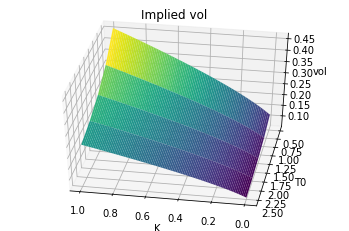

In [45]:
# IV vol. surface in normal model with displaced log-normal approximation prices

strikes = np.arange(0,1,0.01)
T0s = np.arange(0.5,3,0.5)
X,Y = np.meshgrid(strikes, T0s)
surface = np.zeros((T0s.size,strikes.size))
i,j= 0,0
compteur = 0
for t in T0s:
    maturities = np.arange(t,t + 5.5,0.5)
    bonds = [np.exp(-r*m) for m in maturities]
    for k in strikes:
        Price = Swaption_LD(k,lmbda,a,b,chi,maturities,bonds)
        surface[i][j] = biss_python(Price,bonds,k,maturities,"normal")
        j = (j+1)%strikes.size
        compteur +=1
    i+=1
    print(compteur*100/(T0s.size*strikes.size),'%')
plot3D(X,Y,surface,100)

20.0 %
40.0 %
60.0 %
80.0 %
100.0 %


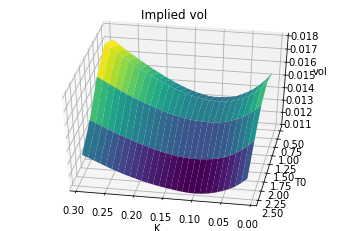

In [25]:
#3D Plot of the difference between IV. with MC prices and IV. with LD Approx prices

strikes = np.arange(0.01,0.3,0.01)
T0s = np.arange(0.5,3,0.5)
X,Y = np.meshgrid(strikes, T0s)
surface = np.zeros((T0s.size,strikes.size))
vol_MC = np.zeros((T0s.size,strikes.size))
vol_Approx = np.zeros((T0s.size,strikes.size))
i,j= 0,0
compteur = 0
for t in T0s:
    maturities = np.arange(t,t + 5.5,0.5)
    bonds = [np.exp(-r*m) for m in maturities]
    sim = simul(lmbda,a,b,chi,t,N,M,"Euler")
    for k in strikes:
        Price_Approx = Swaption_LD(k,lmbda,a,b,chi,maturities,bonds)
        Price_MC = swaption_MC(M,sim,k,chi,bonds,maturities)
        vol_MC[i][j] = biss_python(Price_MC,bonds,k,maturities,"normal")
        vol_Approx[i][j] = biss_python(Price_Approx,bonds,k,maturities,"normal")
        surface[i][j] = vol_MC[i][j] - vol_Approx[i][j]
        j = (j+1)%strikes.size
        compteur +=1
    i+=1
    print(compteur*100/(T0s.size*strikes.size),'%')
plot3D(X,Y,surface,100)

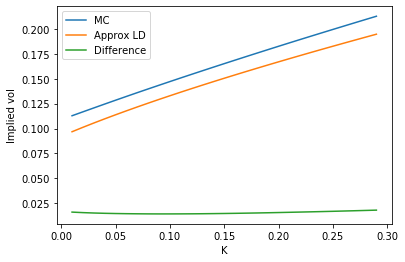

In [28]:
#2D plot of the Implied vol. with MC and LD Approximation prices
plt.plot(strikes,vol_MC[1][:],label="MC")
plt.plot(strikes,vol_Approx[1][:],label="Approx LD")
plt.plot(strikes,surface[1][:],label="Difference")
plt.legend()
plt.xlabel("K")
plt.ylabel("Implied vol")
plt.show()

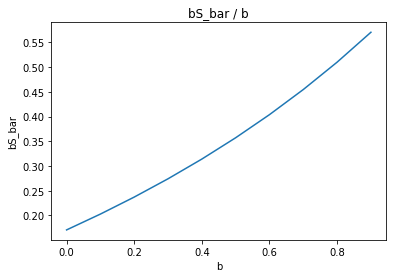

In [51]:
def wS(t,b):
    f = lambda s: integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbda,a,chi),y0(u,lmbda,a,chi),lmbda,a,b,chi,maturities,bonds,np.exp(-r*u))**2 ,0,s)[0]
    denom_w = integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbda,a,chi),y0(u,lmbda,a,chi),lmbda,a,b,chi,maturities,bonds,np.exp(-r*u))**2 * f(u),0,T0)[0]
    return (lS(t,x_bar(t,maturities,bonds,np.exp(-r*t),lmbda,a,chi),y0(t,lmbda,a,chi),lmbda,a,b,chi,maturities,bonds,np.exp(-r*t))**2 * f(t)) / denom_w

curve = []
b_vals = np.arange(0,1,0.1)
for b in b_vals:
    curve.append(integrate.quad(lambda u: bS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbda,a,chi),y0(u,lmbda,a,chi),lmbda,a,b,chi,maturities,bonds,np.exp(-r*u)) * wS(u,b),0,T0)[0])
plt.plot(b_vals,curve)
plt.xlabel("b")
plt.ylabel("bS_bar")
plt.title("bS_bar / b")
plt.show()

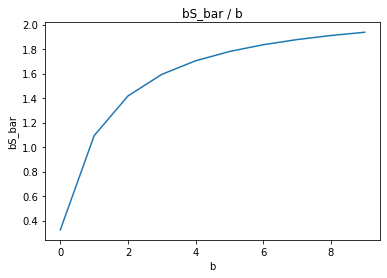

In [28]:
def wS(t,b):
    f = lambda s: integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbda,a,chi),y0(u,lmbda,a,chi),lmbda,a,b,chi,maturities,bonds,np.exp(-r*u))**2 ,0,s)[0]
    denom_w = integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbda,a,chi),y0(u,lmbda,a,chi),lmbda,a,b,chi,maturities,bonds,np.exp(-r*u))**2 * f(u),0,T0)[0]
    return (lS(t,x_bar(t,maturities,bonds,np.exp(-r*t),lmbda,a,chi),y0(t,lmbda,a,chi),lmbda,a,b,chi,maturities,bonds,np.exp(-r*t))**2 * f(t)) / denom_w

curve = []
b_vals = np.arange(0,10,1)
for b in b_vals:
    curve.append(integrate.quad(lambda u: bS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbda,a,chi),y0(u,lmbda,a,chi),lmbda,a,b,chi,maturities,bonds,np.exp(-r*u)) * wS(u,b),0,T0)[0])
plt.plot(b_vals,curve)
plt.xlabel("b")
plt.ylabel("bS_bar")
plt.title("bS_bar / b")
plt.show()

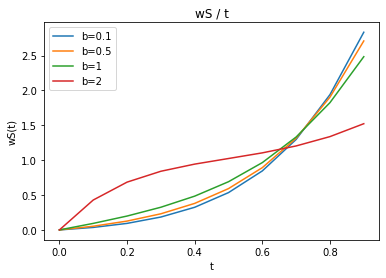

In [52]:
T0 = 1
maturities = np.arange(T0,T0 + 5.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
tim = np.arange(0,T0,0.1)
for bi in [0.1,0.5,1,2]:
    curve = [wS(t,bi) for t in tim]
    plt.plot(tim,curve,label="b="+str(bi))
plt.xlabel("t")
plt.ylabel("wS(t)")
plt.legend()
plt.title("wS / t")
plt.show()

--- 
## 11.In which model should the implied volatility be computed?

The two mainly used models to compute implied volatility are the normal model and the log-normal model. 

We have shown earlier that the price of a swaption, under the assumption that the swap rate is log-normal, is bounded from below and above. Therefore the main problem of this modelization is that inversion issues can occur when prices generated by the Monte Carlo method aren't between the bounds of the log-normal model. We have indeed observed that these issues happen for low values of the strike $K$ and high maturities $T_0$.

However, using the normal model to compute implied volatility is a solution to avoid these issues because the swaption price under the normal model is only bounded from below by $0$ if $S(0) < K$ and by $A(0) (S(0)-K)$ if $S(0) \ge K$. 
Since the Monte Carlo approximation seems to overestimate prices, the normal model can be used to compute the whole implied volatility surface.

**Moreover, it is possible to compute log-normal vol. from the normal vol (see "Volatility conversions calculators", Patrick Hagan)**

-----

## $\chi$ piecewise constant 
(see "One factor Gaussian short rate model implementation", Caspers)

$$\chi(t) = \sum_{i=0}^{N-1} \chi_i \ \mathbb{1}_{t \in [t_i,t_{i+1}[}$$

Then closed formulas for $G$ and $y$ will change.
One notes $U(t) = \inf { \{i \in [|0,N|], \ t_i \ge t\}}$ and $l(t) = \sup { \{i \in [|0,N|], \ t_i \le t\}}$

**changes for G:** 
$$e^{-\int_{t}^{u} \chi(s) \ \mathrm{d}s} = \prod_{i=l(t)}^{U(u)-1} e^{-\chi_{i}\left(t_{i+1} \wedge u-t_i \vee t\right)}$$

$$G\left(t, T \right)=\sum_{i=l(t)}^{U\left(T\right)-1} \int_{t_i \vee t}^{T \wedge t_{i+1}}\left(\prod_{j=l(t)}^{i-1} e^{-\kappa_{j}\left(t_{j+1}-t_j \vee t\right)}\right) e^{-\kappa_{i}\left(u-t_i \vee t\right)} d u \\
= \sum_{i=l(t)}^{U\left(T\right)-1} \Big( \frac{1-e^{\chi_i(T \wedge t_{i+1} - t \vee t_i)}}{\chi_i} \Big) \prod_{j=l(t)}^{i-1} e^{-\kappa_{j}\left(t_{j+1}-t_j \vee t\right)}
$$

**changes for y:** 

In [13]:
maturities = np.arange(1,7,1)
bonds = [np.exp(-r*m) for m in maturities]
S0 = S(0,0,0,maturities,bonds,1,chi)
A0 = A(0,0,0,maturities,bonds,1,chi)
strikes = np.arange(0,0.5,0.01) # 40% to 140% of the strike ATM
    
#IV log_displaced (l,b)
prix_LD = [log_displaced(0.1,0.1,strikes[m],maturities,bonds)  for m in range(len(strikes))]
IV_LD = [biss_python(prix_LD[m], bonds, strikes[m], maturities) for m in range(len(strikes))]

!! Le prix d'entrée est en-dessous des limites BS!! 0.21041120381899603 < 0.21041120381899614


NameError: name 'Price_BS' is not defined